In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam


In [81]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data.head(9)) 

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   
06/01/2008        199        346.358         393.919               0.0   
07/01/2008        190        421.766        1109.965               0.0   
08/01/2008        178        423.221        1037.933               0.0   
09/01/2008        200        538.175        1033.090               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2008               0.0        23.230         90.200  
02/01

In [38]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [82]:
# Xác định số lượng đầu vào
n_steps = 7  # Số bước thời gian nghĩa là nó sẽ lấy dữ liệu mực nước thời gian 7 hoặc 30 ngày trước đó làm cơ sở để dự đoán cho ngày kế tiếp  
X, y = [], []
# X chứa dữ liệu đầu vào của 7 ngày trc trong file 
#y chứa dữ liệu mà ta muốn dự doán cho ngày kế tiếp ở đây sẽ là dữ liệu kế tiếp sau 7 ngày 
# Ví dụ:
# dữ liệu 7 ngày : 
#      mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
# Ngay                                                                     
# 01/01/2008        120        498.815         259.499               0.0   
# 02/01/2008        117        470.866         518.755               0.0   
# 03/01/2008        139        423.816         615.242               0.0   
# 04/01/2008        166        496.882         902.982               0.0   
# 05/01/2008        179        501.232        1072.970               0.0   
# 06/01/2008        199        346.358         393.919               0.0   
# 07/01/2008        190        421.766        1109.965               0.0 
# Sẽ là dữ liệu X 
# Dữ liệu này kế tiếp : 
# 08/01/2008        178        423.221        1037.933               0.0   
#Sẽ là y 
for i in range(n_steps, len(data_scaled)):
    X.append(data_scaled[i-n_steps:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)
y_scare = scaler.inverse_transform(y)
print(y_scare)

[[ 178.     423.221 1037.933 ...    0.      26.152  187.601]
 [ 200.     538.175 1033.09  ...    0.      24.047  161.976]
 [ 212.     137.713  771.954 ...    0.      16.7    161.3  ]
 ...
 [  84.     268.     474.    ...   94.274   95.65    85.65 ]
 [  80.     543.     345.    ...  115.226  113.294   75.867]
 [  77.     812.     380.59  ...  113.     171.      23.   ]]


In [40]:
# 2. Xây dựng mô hình với LSTM và Attention
input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)

In [41]:
# Áp dụng lớp Attention
attention = Attention()([lstm_out, lstm_out])
attention_output = concatenate([lstm_out, attention], axis=-1)
attention_output = LSTM(32)(attention_output)

In [42]:
# Lớp đầu ra
output_layer = Dense(y.shape[1])(attention_output)

In [43]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 7, 7)]               0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 7, 64)                18432     ['input_3[0][0]']             
                                                                                                  
 attention_2 (Attention)     (None, 7, 64)                0         ['lstm_4[0][0]',              
                                                                     'lstm_4[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate  (None, 7, 128)               0         ['lstm_4[0][0]',        

In [44]:
# 3. Huấn luyện mô hình
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
64/64 [==============================] - 6s 28ms/step - loss: 0.0179 - val_loss: 0.0143
Epoch 2/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0097 - val_loss: 0.0131
Epoch 3/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0090 - val_loss: 0.0115
Epoch 4/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0086 - val_loss: 0.0112
Epoch 5/50
64/64 [==============================] - 1s 15ms/step - loss: 0.0082 - val_loss: 0.0107
Epoch 6/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 7/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0074 - val_loss: 0.0093
Epoch 8/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0071 - val_loss: 0.0089
Epoch 9/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0088
Epoch 10/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0080
Epoch 11/

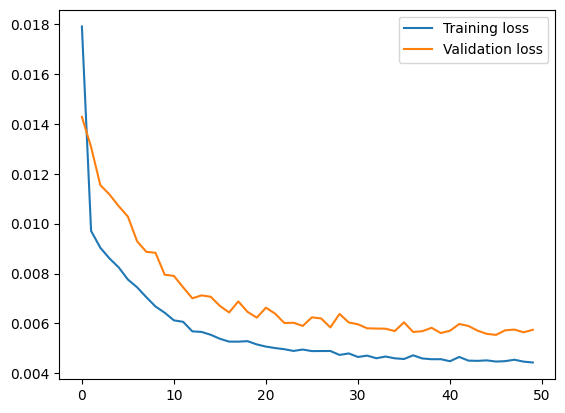

In [45]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [91]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data.set_index('Ngay', inplace=True)
print(new_data.head(5))

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2015         85        575.000         757.694             120.0   
02/01/2015        114        840.327        1045.743             116.0   
03/01/2015        141       1059.445         976.320             115.0   
04/01/2015        147        576.221         671.221             115.0   
05/01/2015        135        875.634         946.884             116.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2015             136.0            93            0.0  
02/01/2015             169.0            61           23.0  
03/01/2015             164.0            43           33.0  
04/01/2015             152.0            71           61.0  
05/01/2015             138.0            33           23.0  


In [92]:
# Chuẩn hóa dữ liệu mới
new_data_scaled = scaler.transform(new_data)  # Sử dụng scaler đã huấn luyện từ dữ liệu ban đầu

# Chia dữ liệu mới thành chuỗi thời gian
X_new = []
for i in range(n_steps, len(new_data_scaled)):
    X_new.append(new_data_scaled[i-n_steps:i])
X_new = np.array(X_new)
print(X_new)
print(len(new_data_scaled))

[[[0.05130785 0.05364276 0.27012264 ... 0.11129296 0.12667785 0.        ]
  [0.0804829  0.07887835 0.3728139  ... 0.13829787 0.11702788 0.0433145 ]
  [0.10764588 0.09971895 0.34806417 ... 0.13420622 0.11159977 0.06214689]
  ...
  [0.10160966 0.08223645 0.33757005 ... 0.11292962 0.10858416 0.0433145 ]
  [0.09356137 0.09259416 0.3255918  ... 0.09410802 0.11009197 0.        ]
  [0.09255533 0.11737189 0.38036471 ... 0.06710311 0.10737791 0.03578154]]

 [[0.0804829  0.07887835 0.3728139  ... 0.13829787 0.11702788 0.0433145 ]
  [0.10764588 0.09971895 0.34806417 ... 0.13420622 0.11159977 0.06214689]
  [0.11368209 0.05375889 0.23929447 ... 0.12438625 0.1200435  0.11487759]
  ...
  [0.09356137 0.09259416 0.3255918  ... 0.09410802 0.11009197 0.        ]
  [0.09255533 0.11737189 0.38036471 ... 0.06710311 0.10737791 0.03578154]
  [0.08651911 0.11143285 0.45176078 ... 0.0695581  0.12697941 0.05461394]]

 [[0.10764588 0.09971895 0.34806417 ... 0.13420622 0.11159977 0.06214689]
  [0.11368209 0.053758

In [93]:
predictions = model.predict(X_new)
predictions_original_scale = scaler.inverse_transform(predictions)
y_original_scale = scaler.inverse_transform(y)
print("Kết quả dự đoán",predictions_original_scale)
print(y_original_scale)

23/23 [==============================] - 0s 6ms/step
Kết quả dự đoán [[ 135.49896  1012.489    1112.0569   ...  137.78386    60.66815
    42.04517 ]
 [ 142.75931  1104.5582   1286.1785   ...  136.35236    65.80067
    52.477135]
 [ 163.87167  1409.9814   1519.19     ...  133.94196   114.85618
    40.940247]
 ...
 [ 143.41911   336.11618   679.39453  ...   98.08676   136.61836
    53.283726]
 [ 144.71466   305.3834    770.2303   ...  112.447105  123.42208
    62.215252]
 [ 161.04813   327.05      733.6537   ...   99.89619   146.21397
    57.02762 ]]
[[ 178.     423.221 1037.933 ...    0.      26.152  187.601]
 [ 200.     538.175 1033.09  ...    0.      24.047  161.976]
 [ 212.     137.713  771.954 ...    0.      16.7    161.3  ]
 ...
 [  84.     268.     474.    ...   94.274   95.65    85.65 ]
 [  80.     543.     345.    ...  115.226  113.294   75.867]
 [  77.     812.     380.59  ...  113.     171.      23.   ]]


In [94]:
# 6. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
dates_new = new_data.index[n_steps:]
dates_new = pd.to_datetime(dates_new, format='%d/%m/%Y')
# Ngày cho dữ liệu mới
columns_new = new_data.columns
print(columns_new)
print(dates_new)


Index(['mucNuocHN', 'nuocVeHoaBinh', 'chayMayHoaBinh', 'nuocVeTuyenQuang',
       'chayMayTuyenQuan', 'nuocVeThacBa', 'chayMayThacBa'],
      dtype='object')
DatetimeIndex(['2015-01-08', '2015-01-09', '2015-01-10', '2015-01-11',
               '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15',
               '2015-01-16', '2015-01-17',
               ...
               '2016-12-29', '2016-12-30', '2016-12-31', '2017-01-01',
               '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07'],
              dtype='datetime64[ns]', name='Ngay', length=731, freq=None)


In [102]:
y_original_scale = y_original_scale[-len(dates_new):]
predictions_original_scale = predictions_original_scale[-len(dates_new):]


In [98]:
# Lấy các năm từ cột ngày
years = dates_new.year
months = dates_new.month
unique_years = years.unique() 
print(unique_years)
print(months)

Index([2015, 2016, 2017], dtype='int32', name='Ngay')
Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       ...
       12, 12, 12,  1,  1,  1,  1,  1,  1,  1],
      dtype='int32', name='Ngay', length=731)


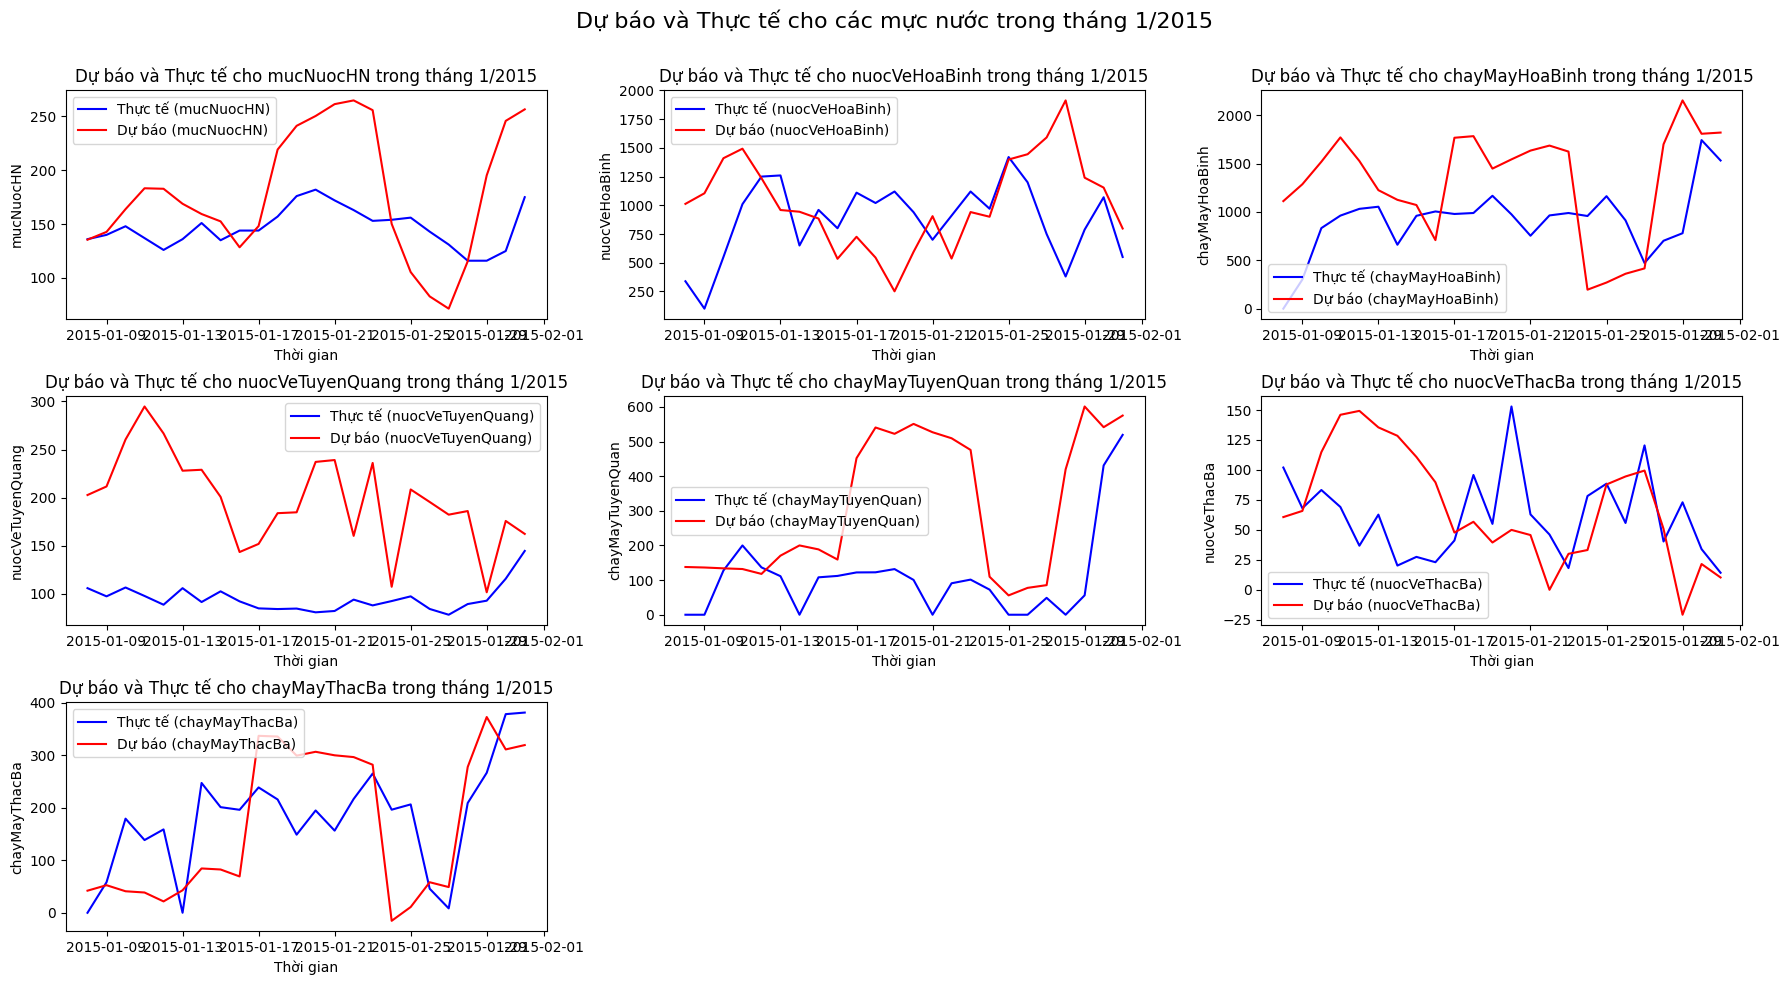

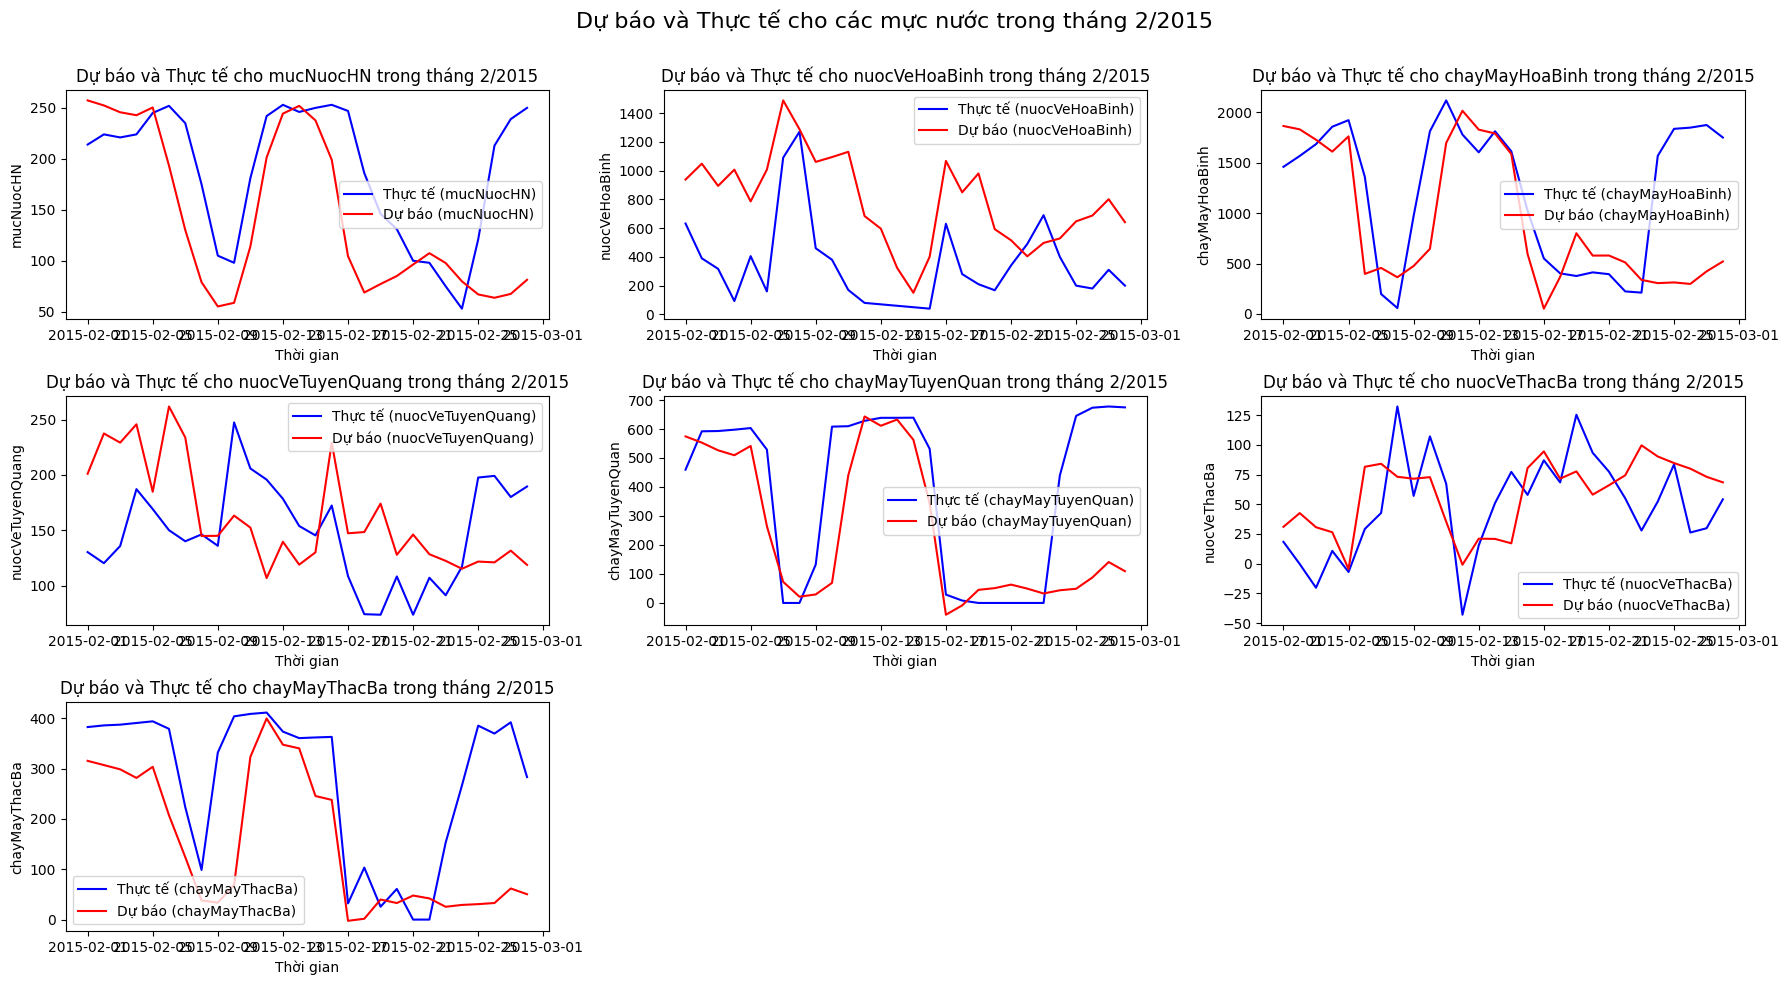

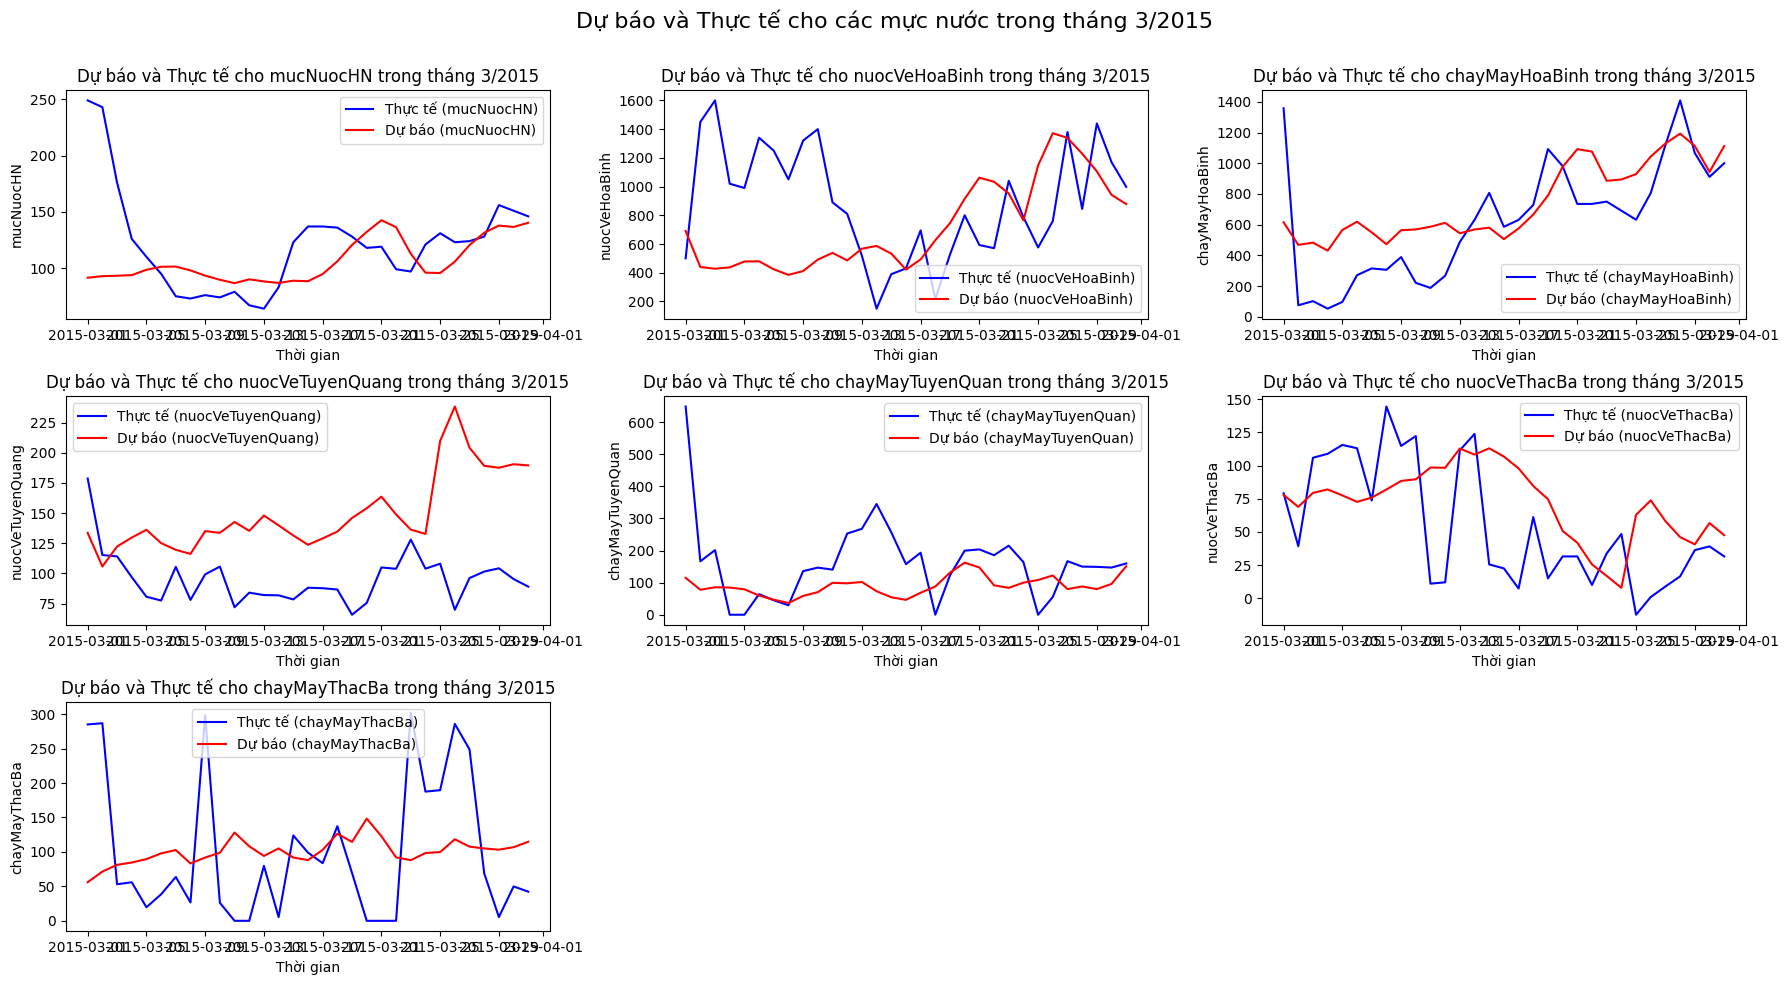

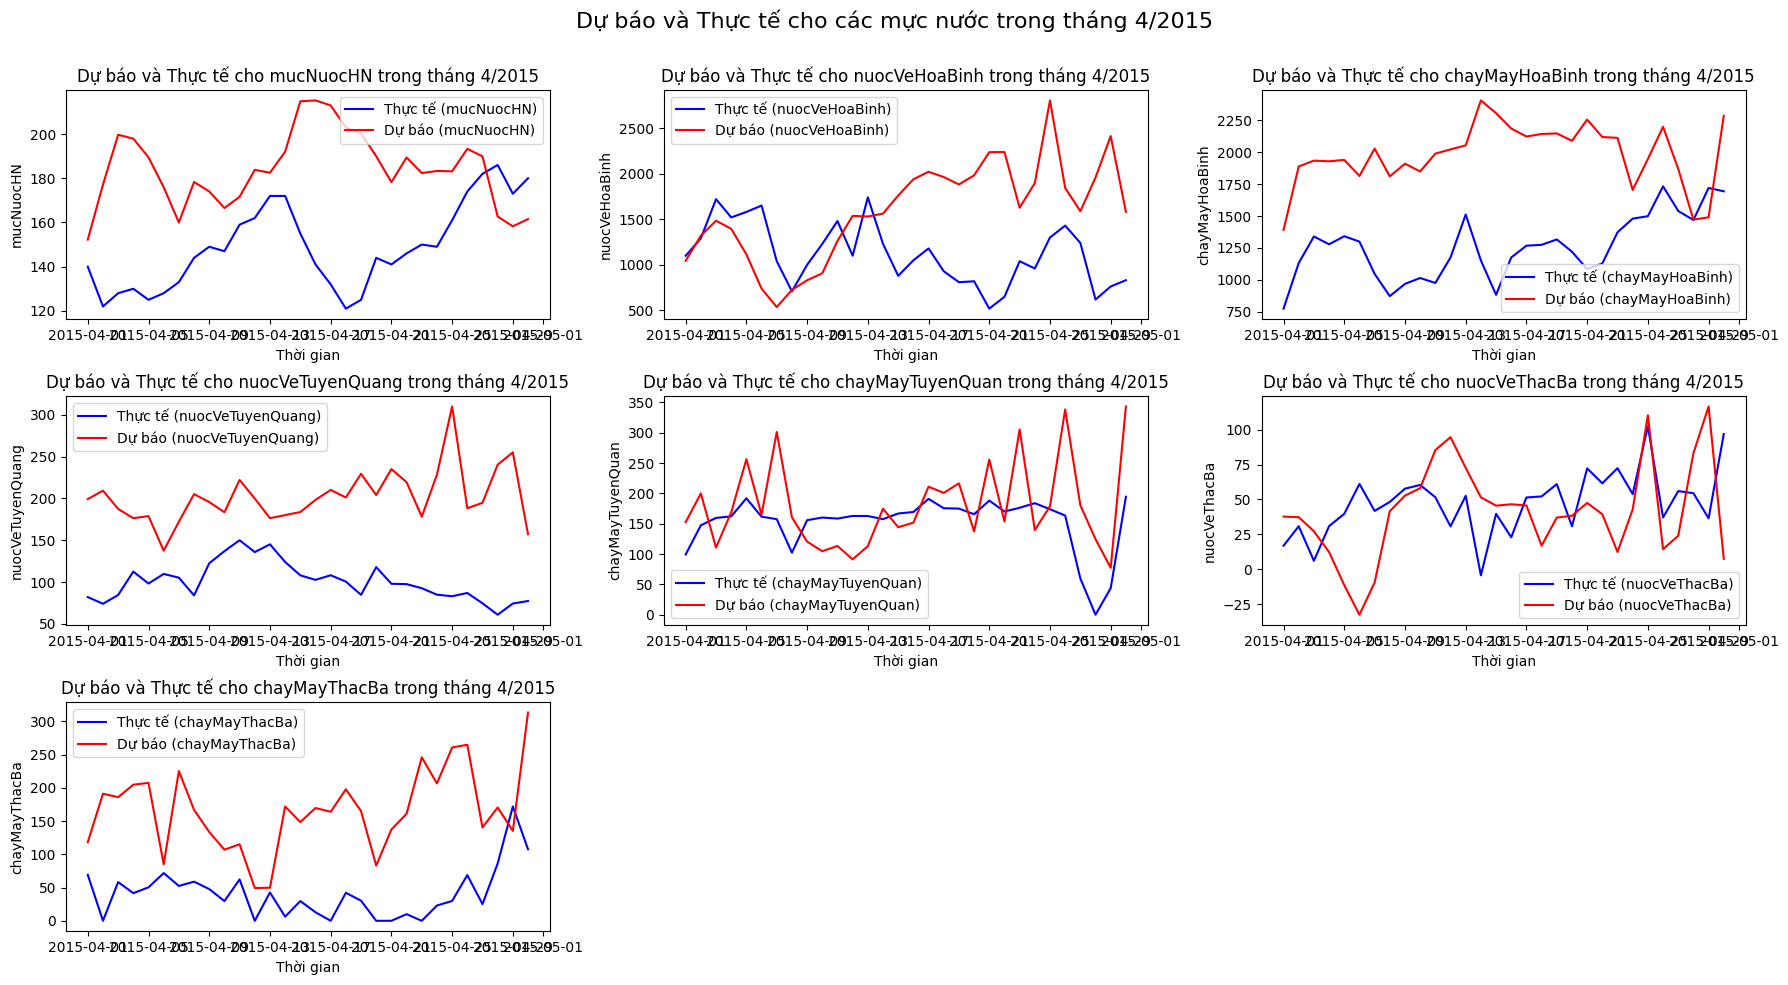

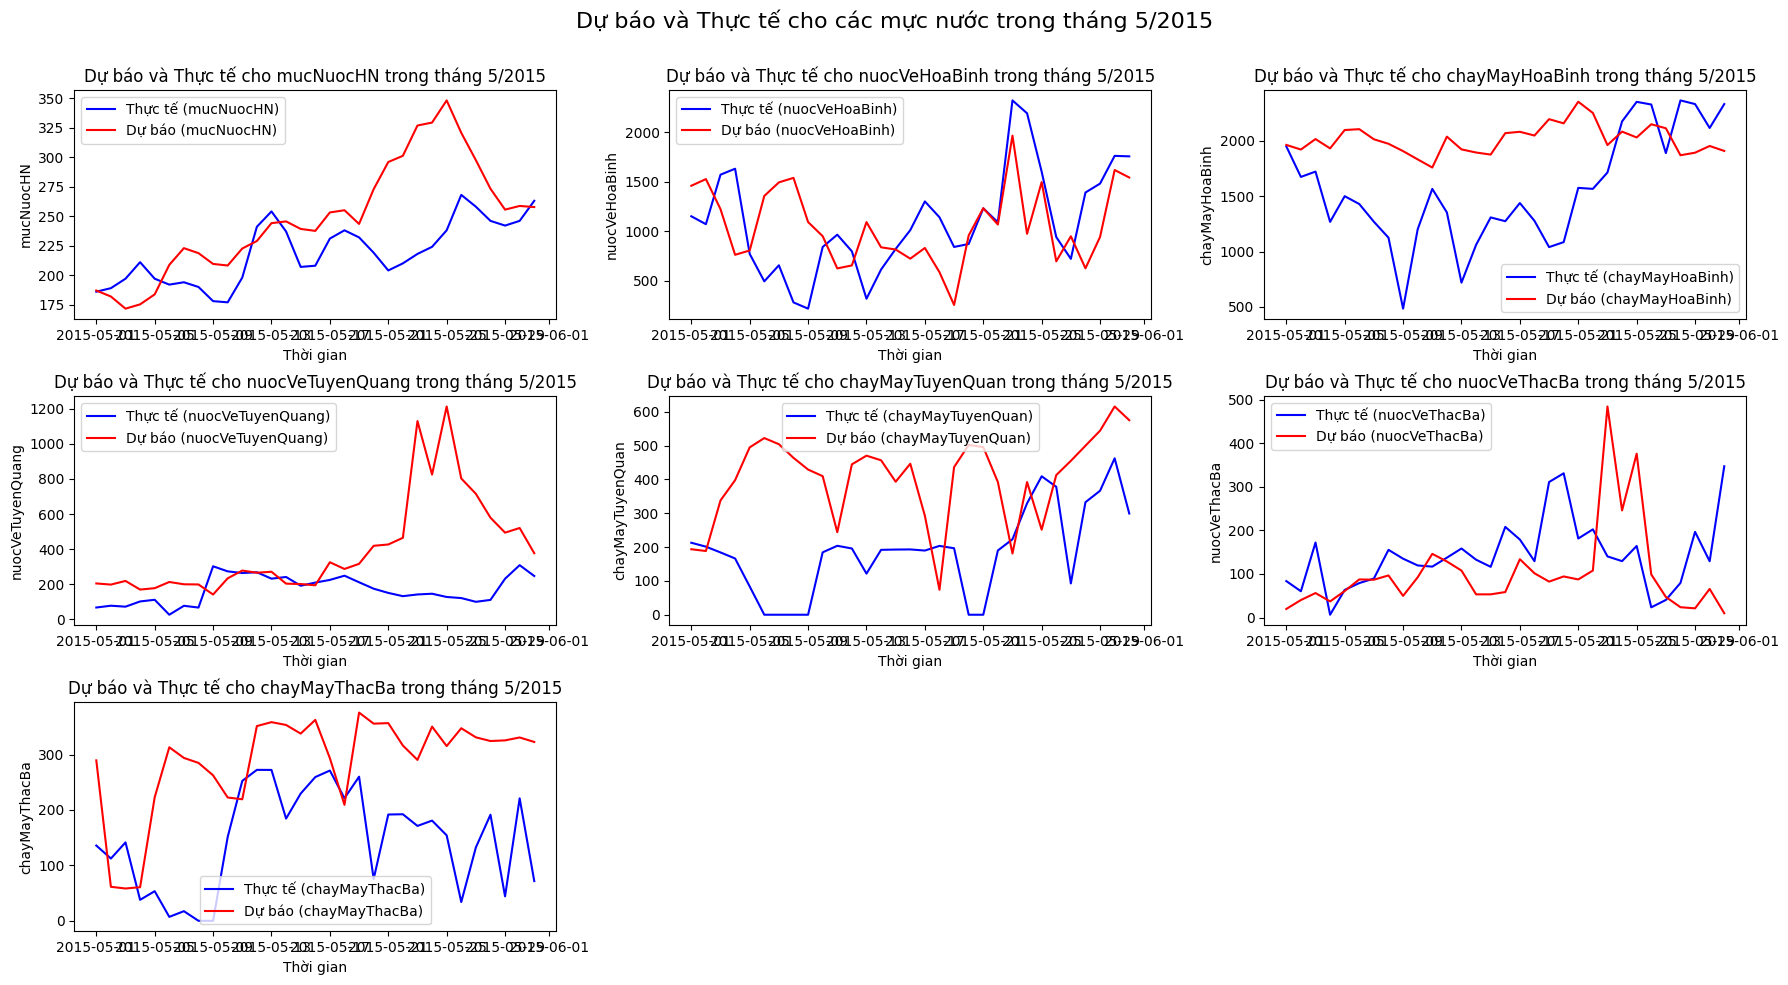

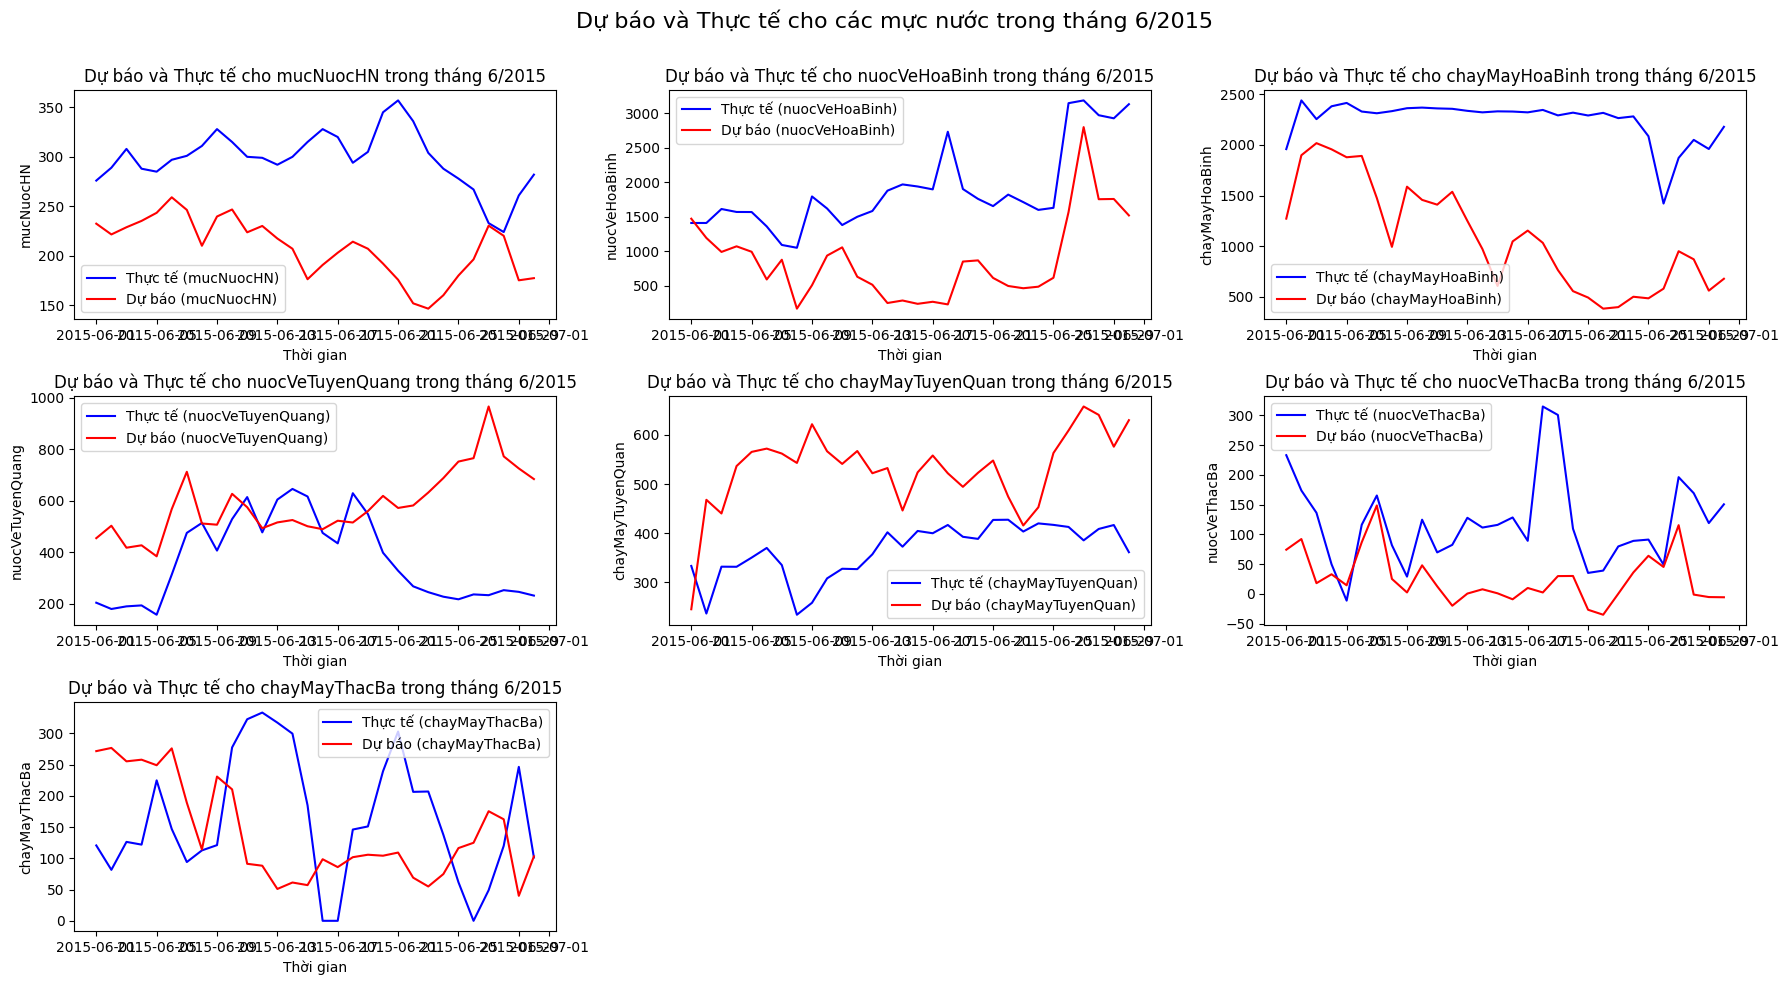

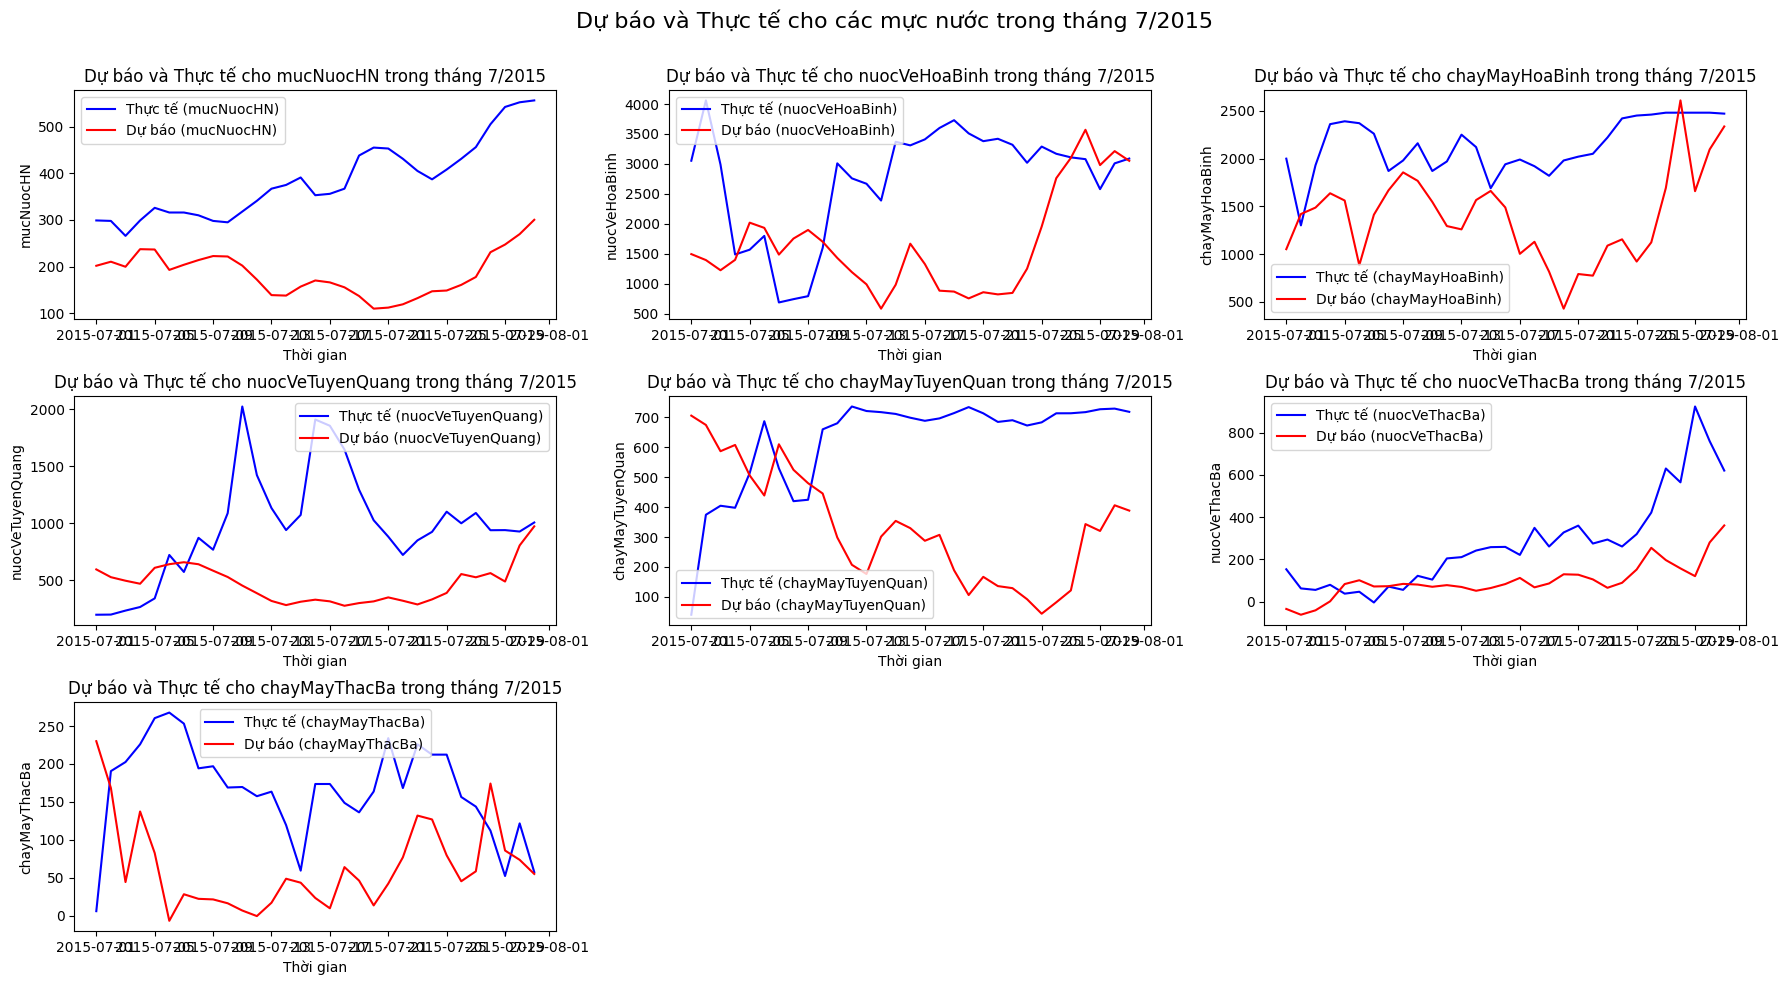

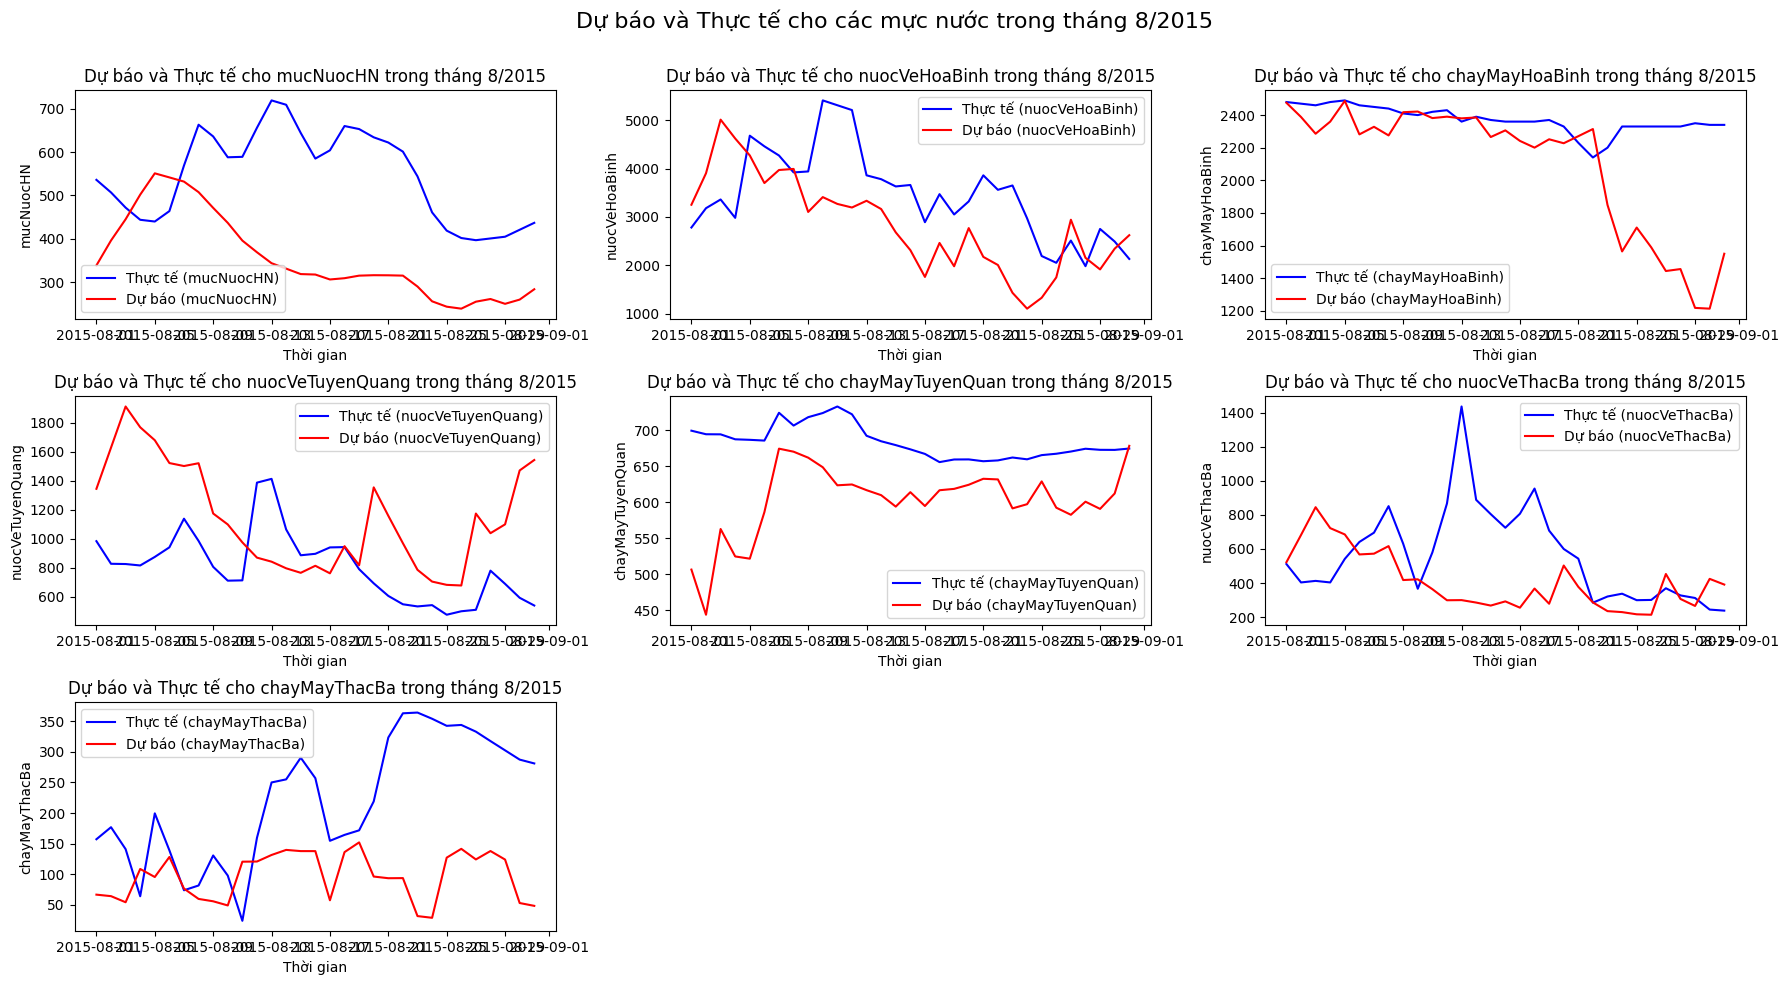

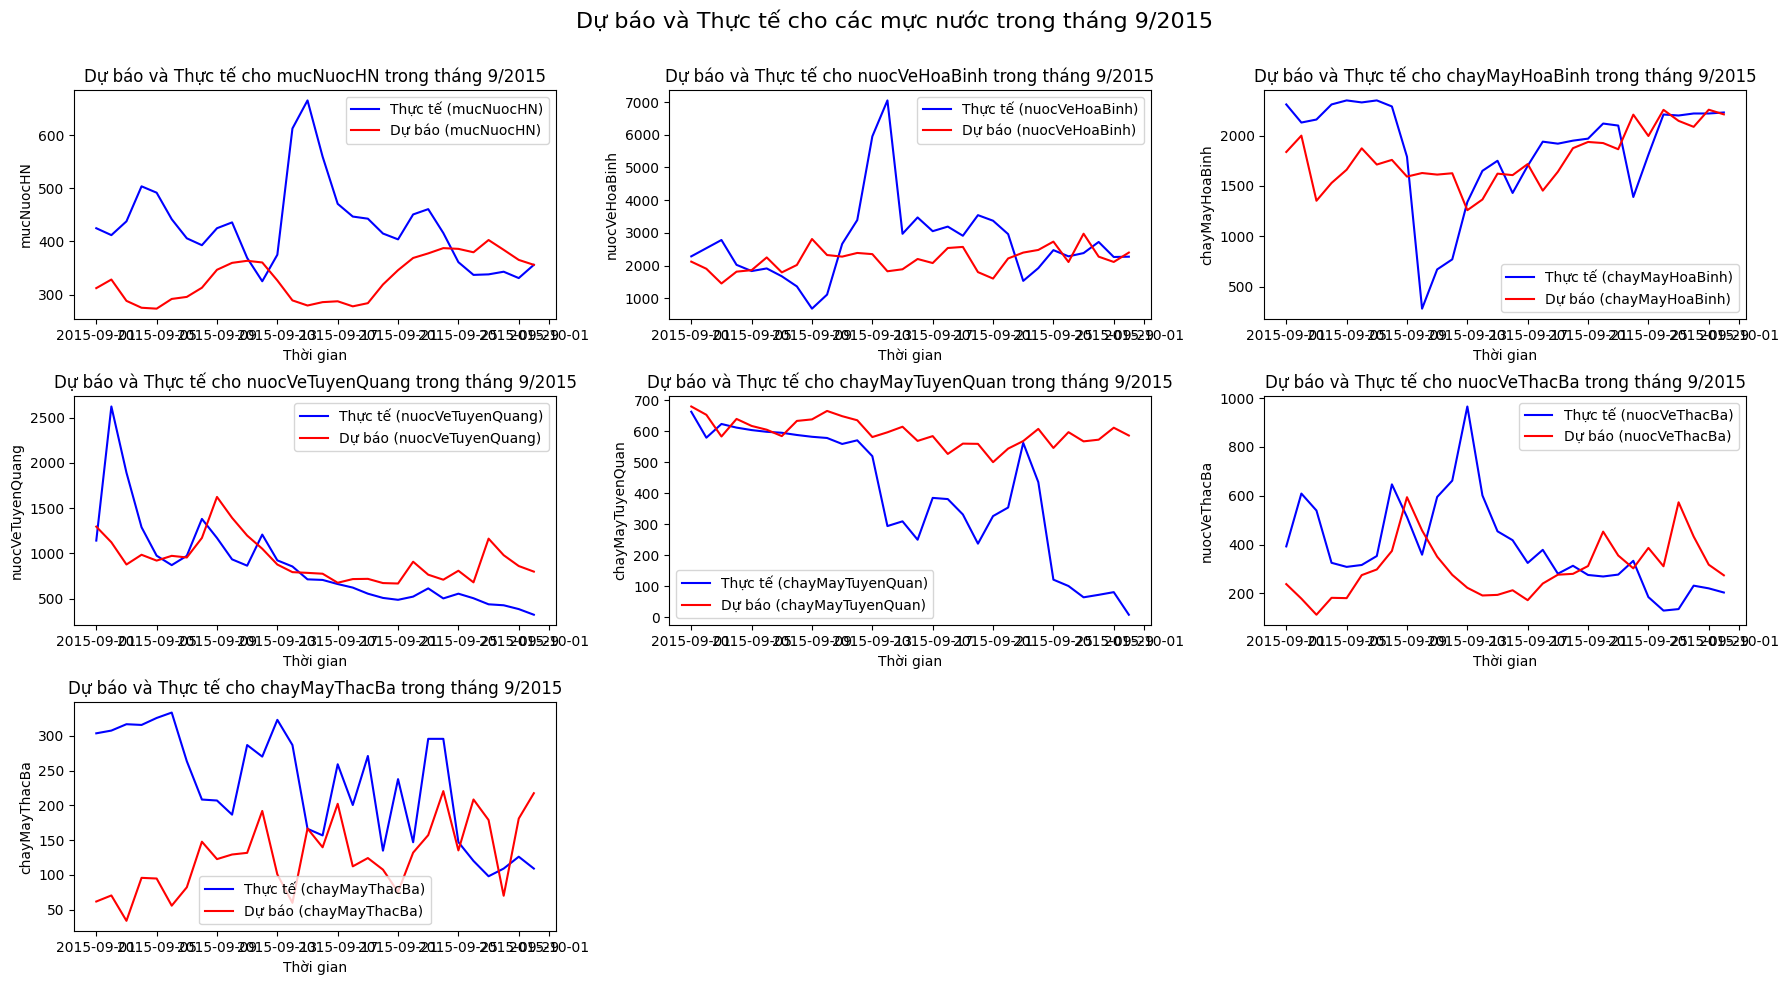

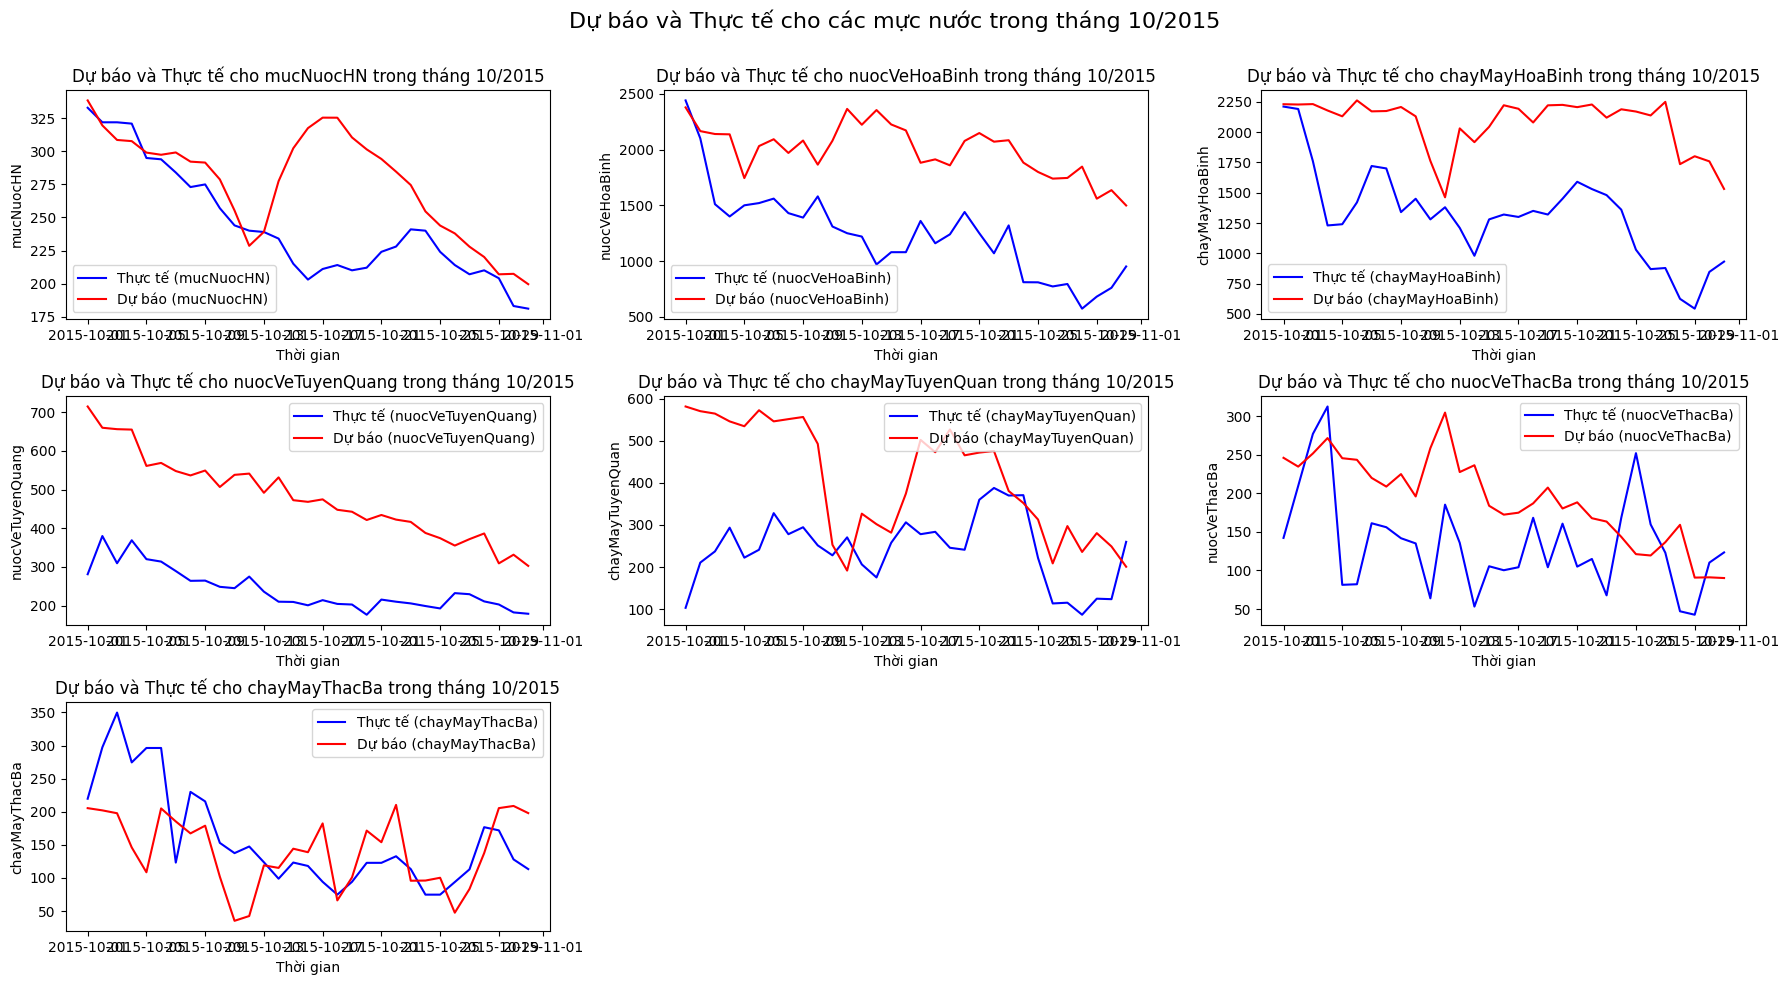

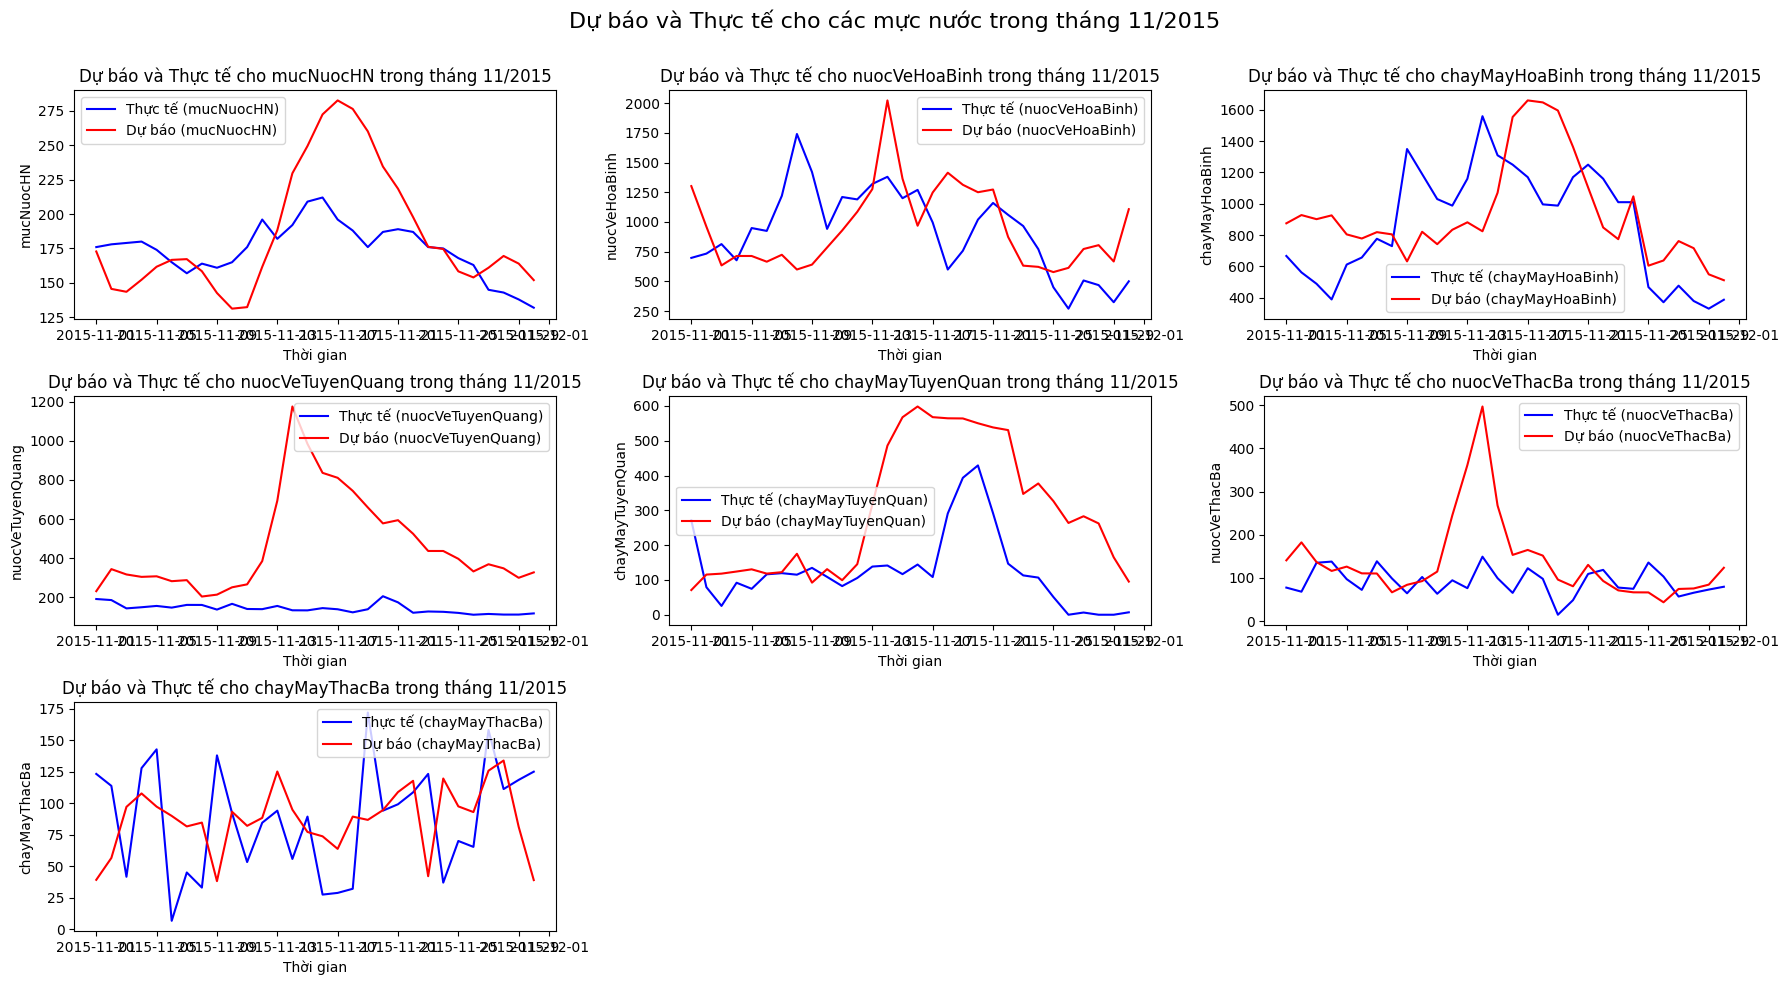

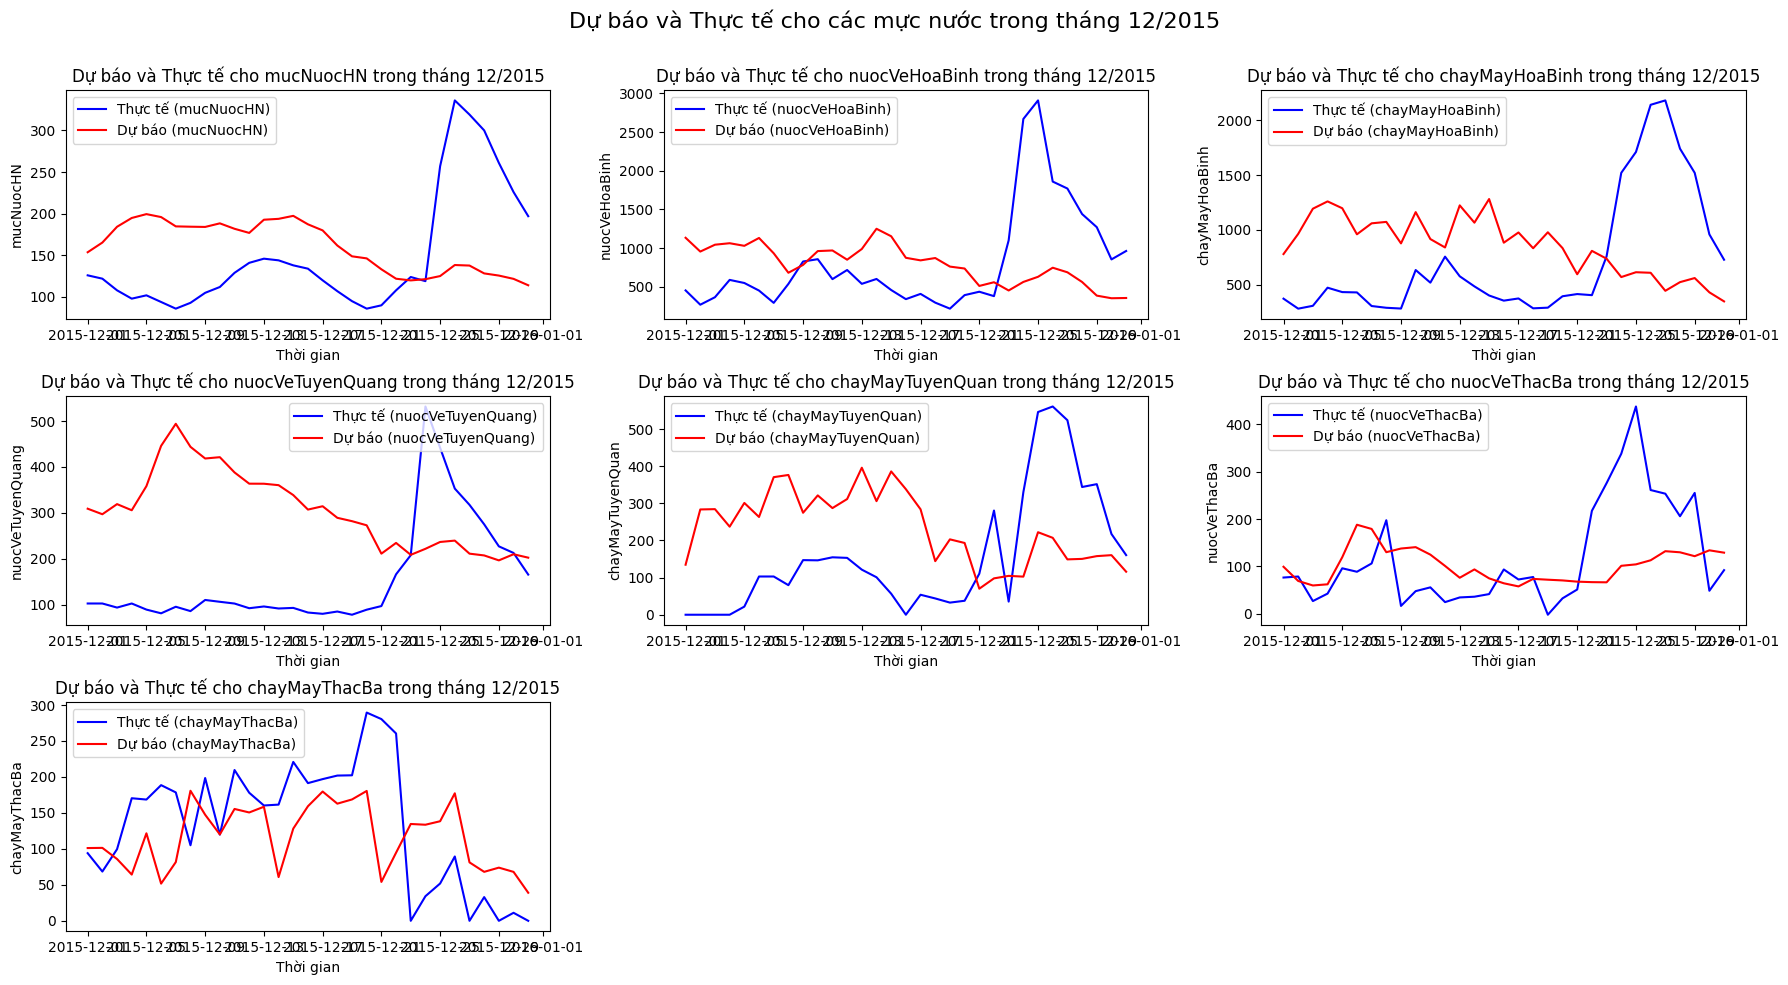

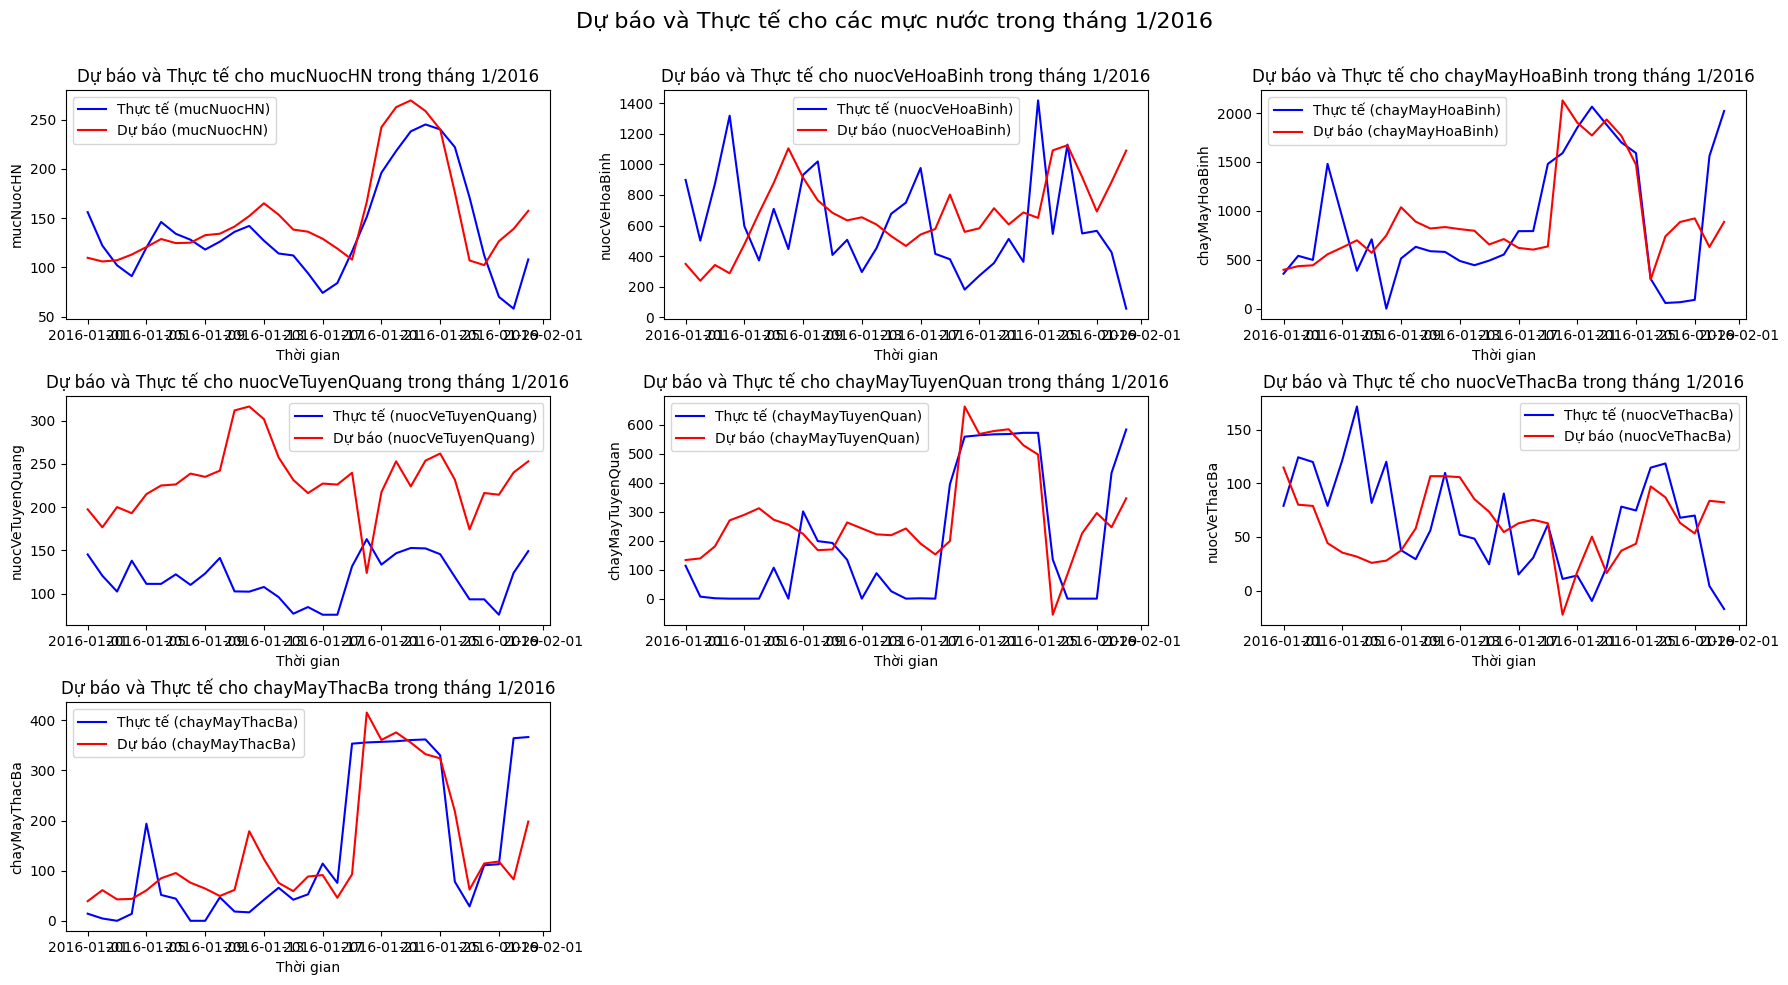

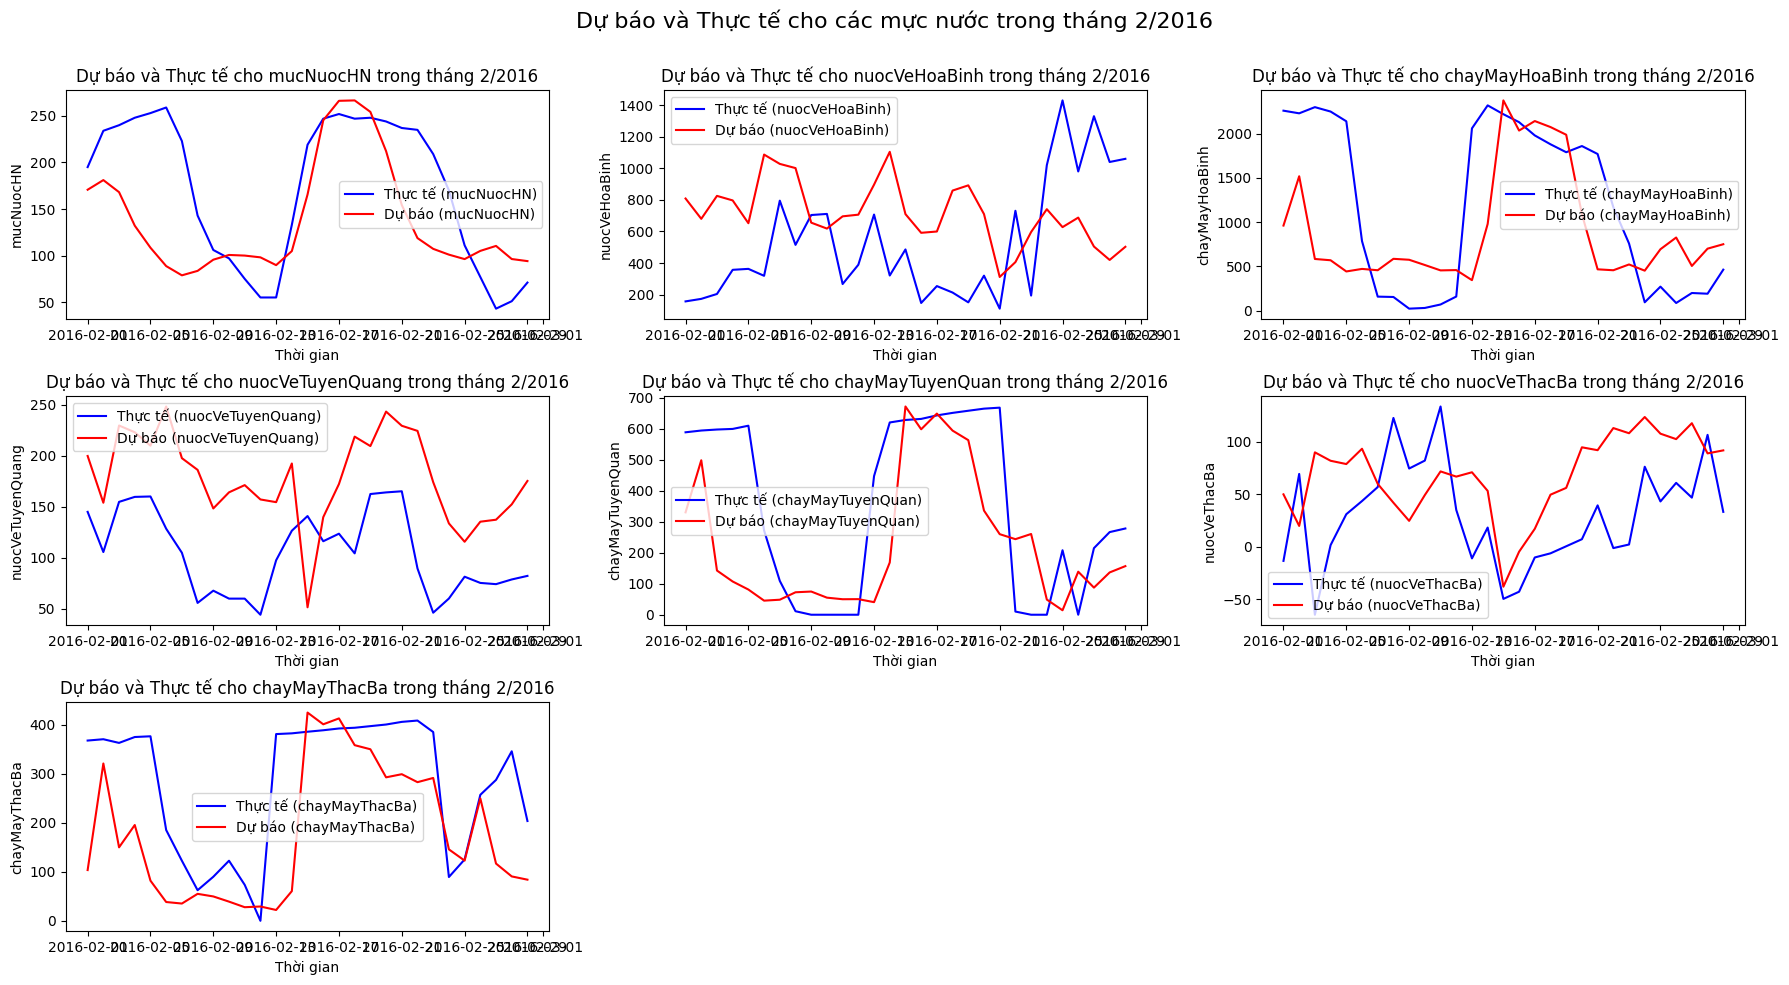

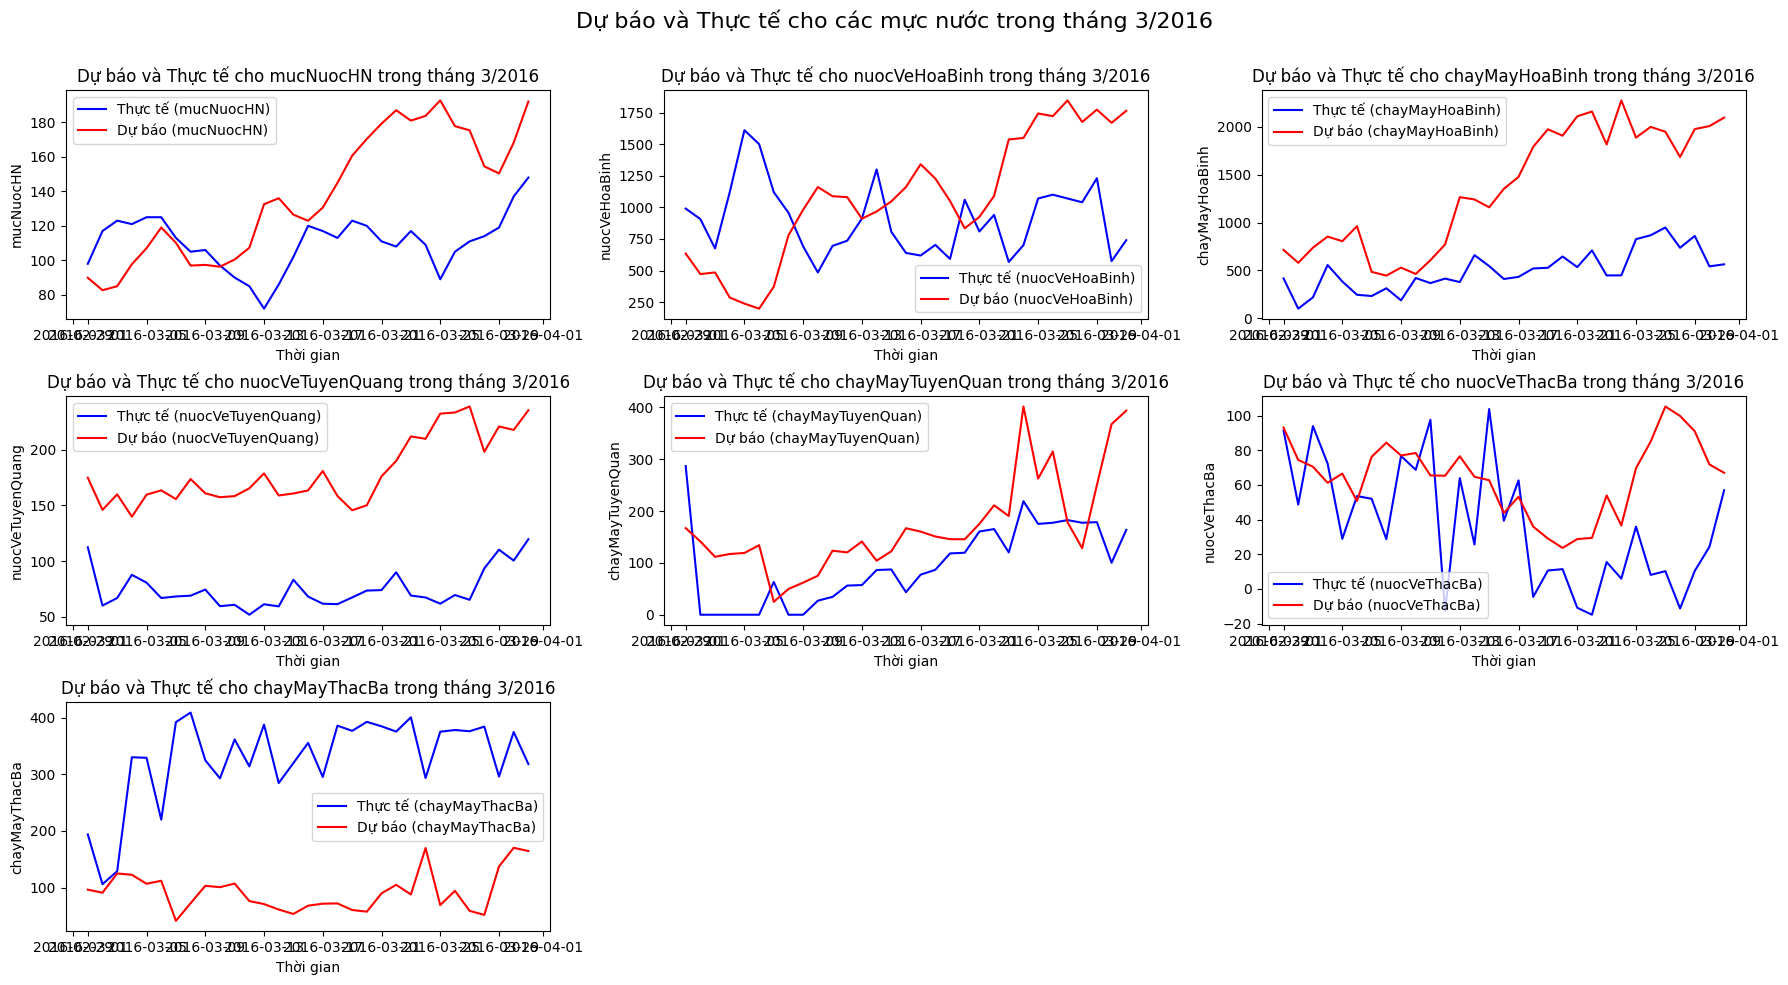

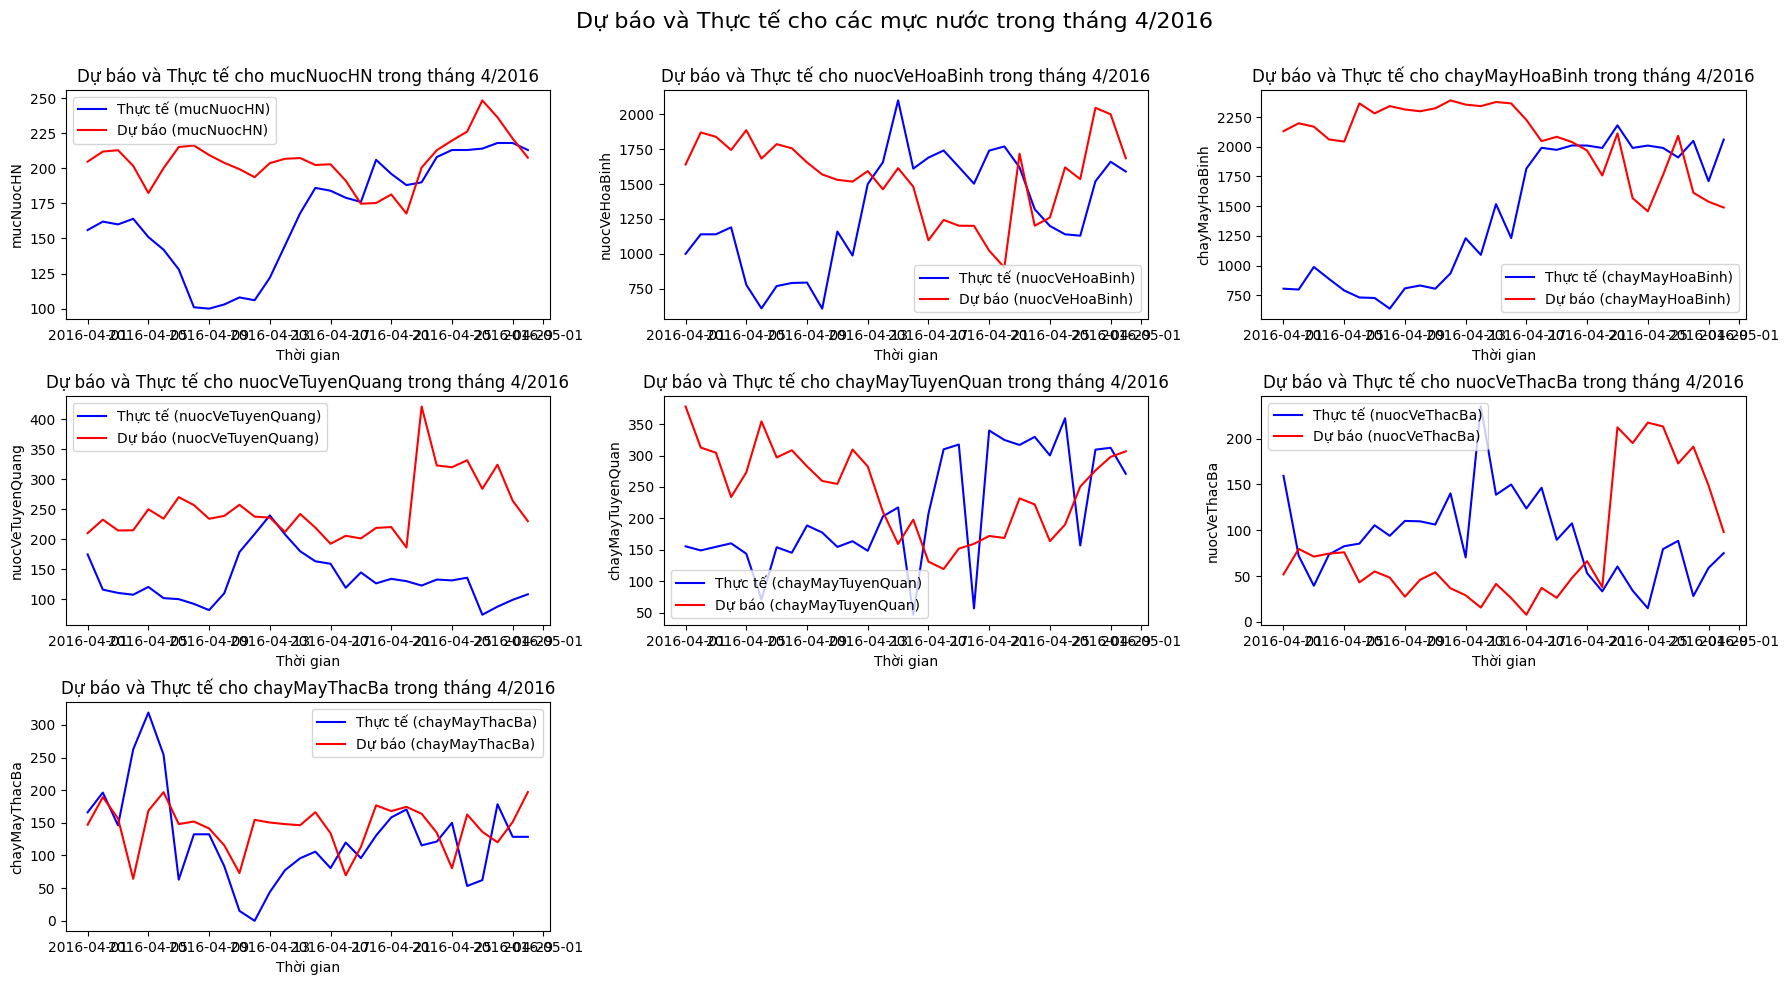

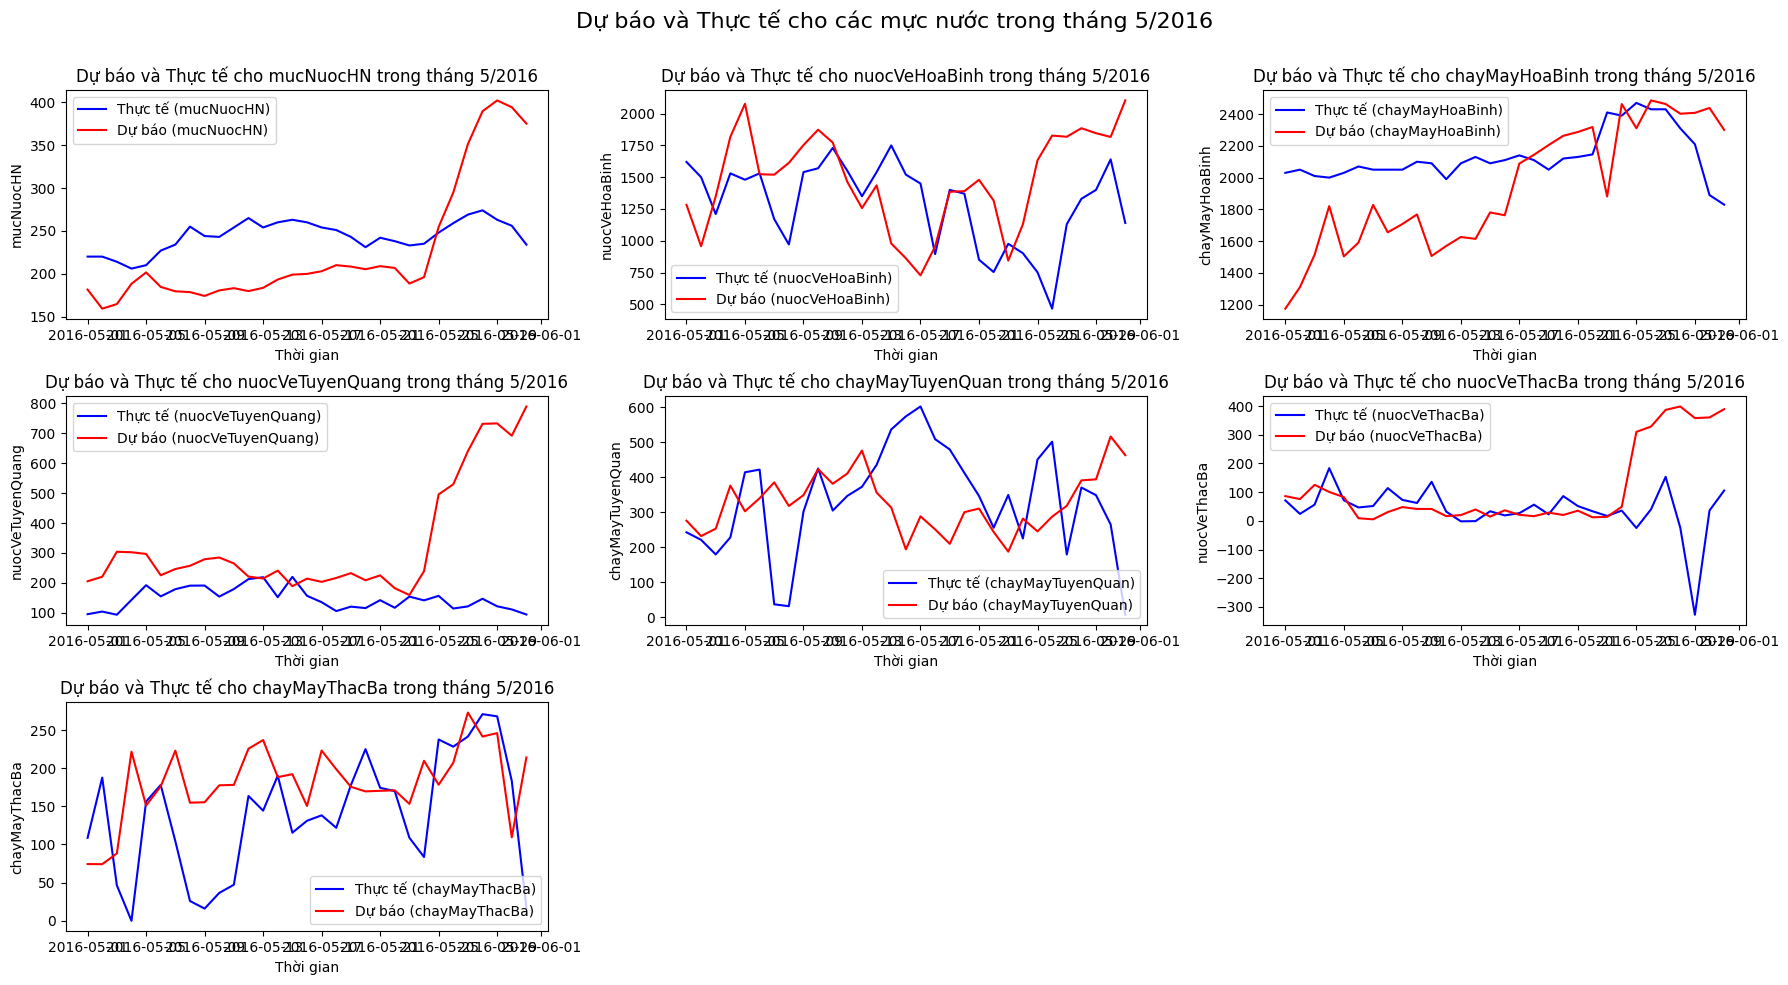

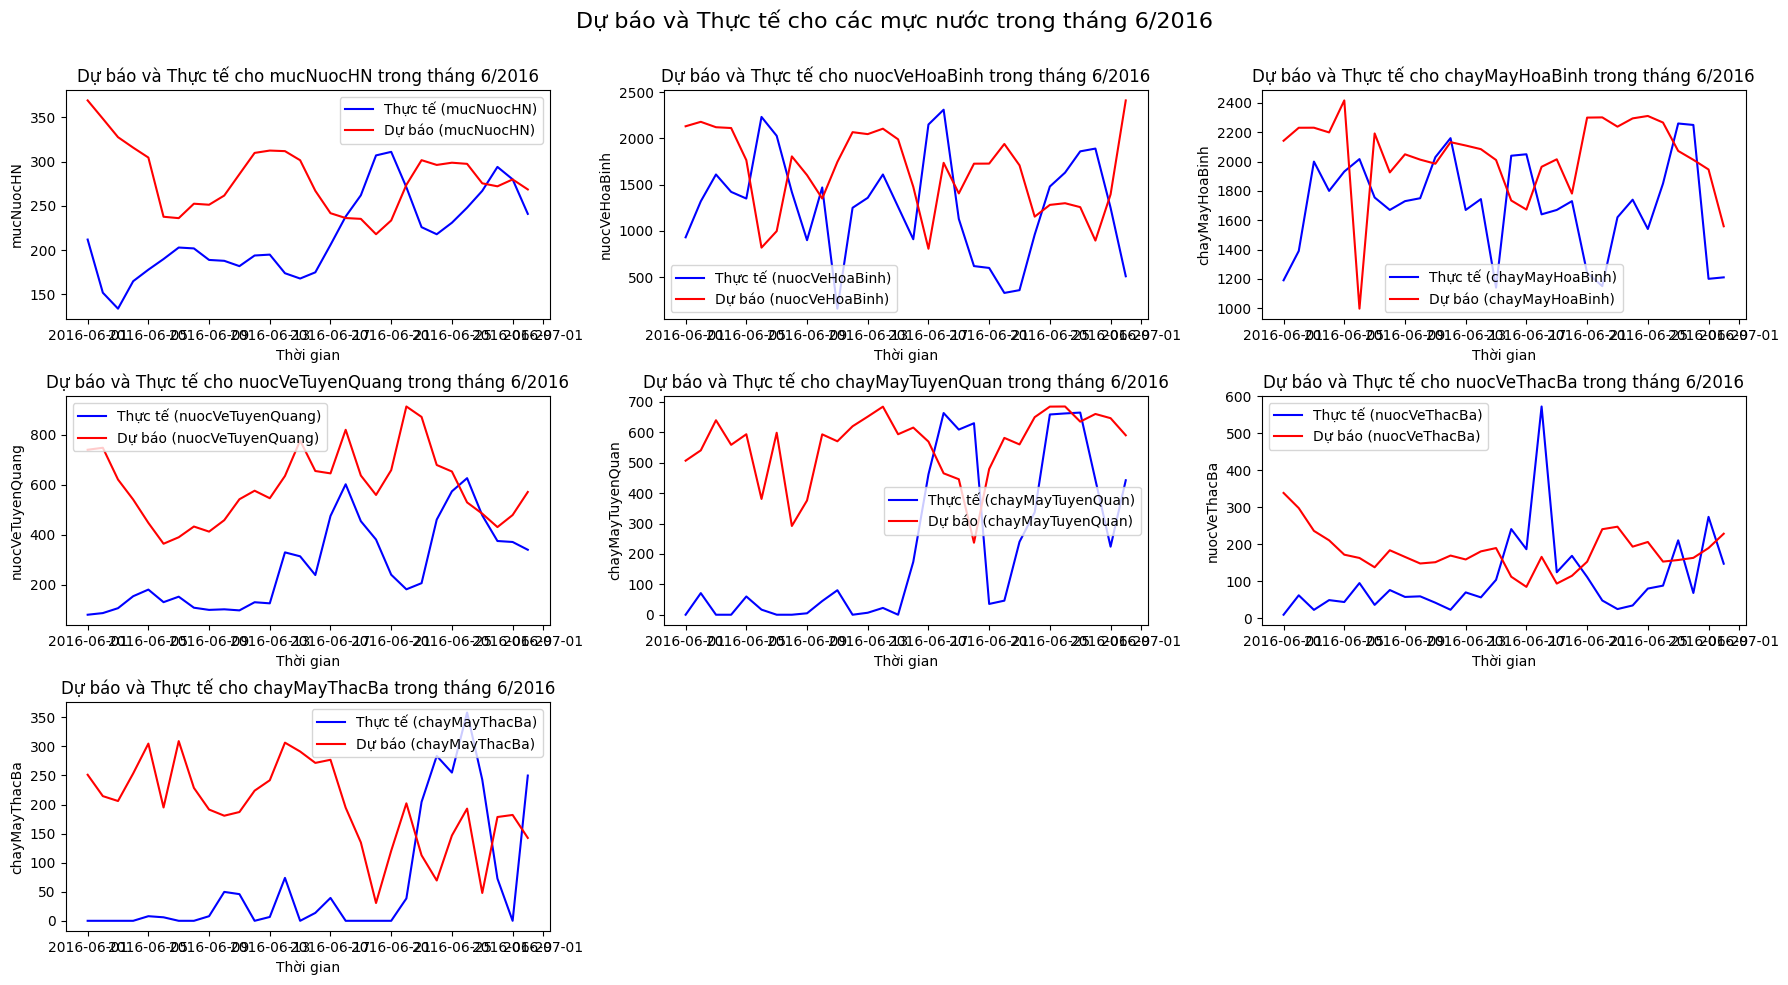

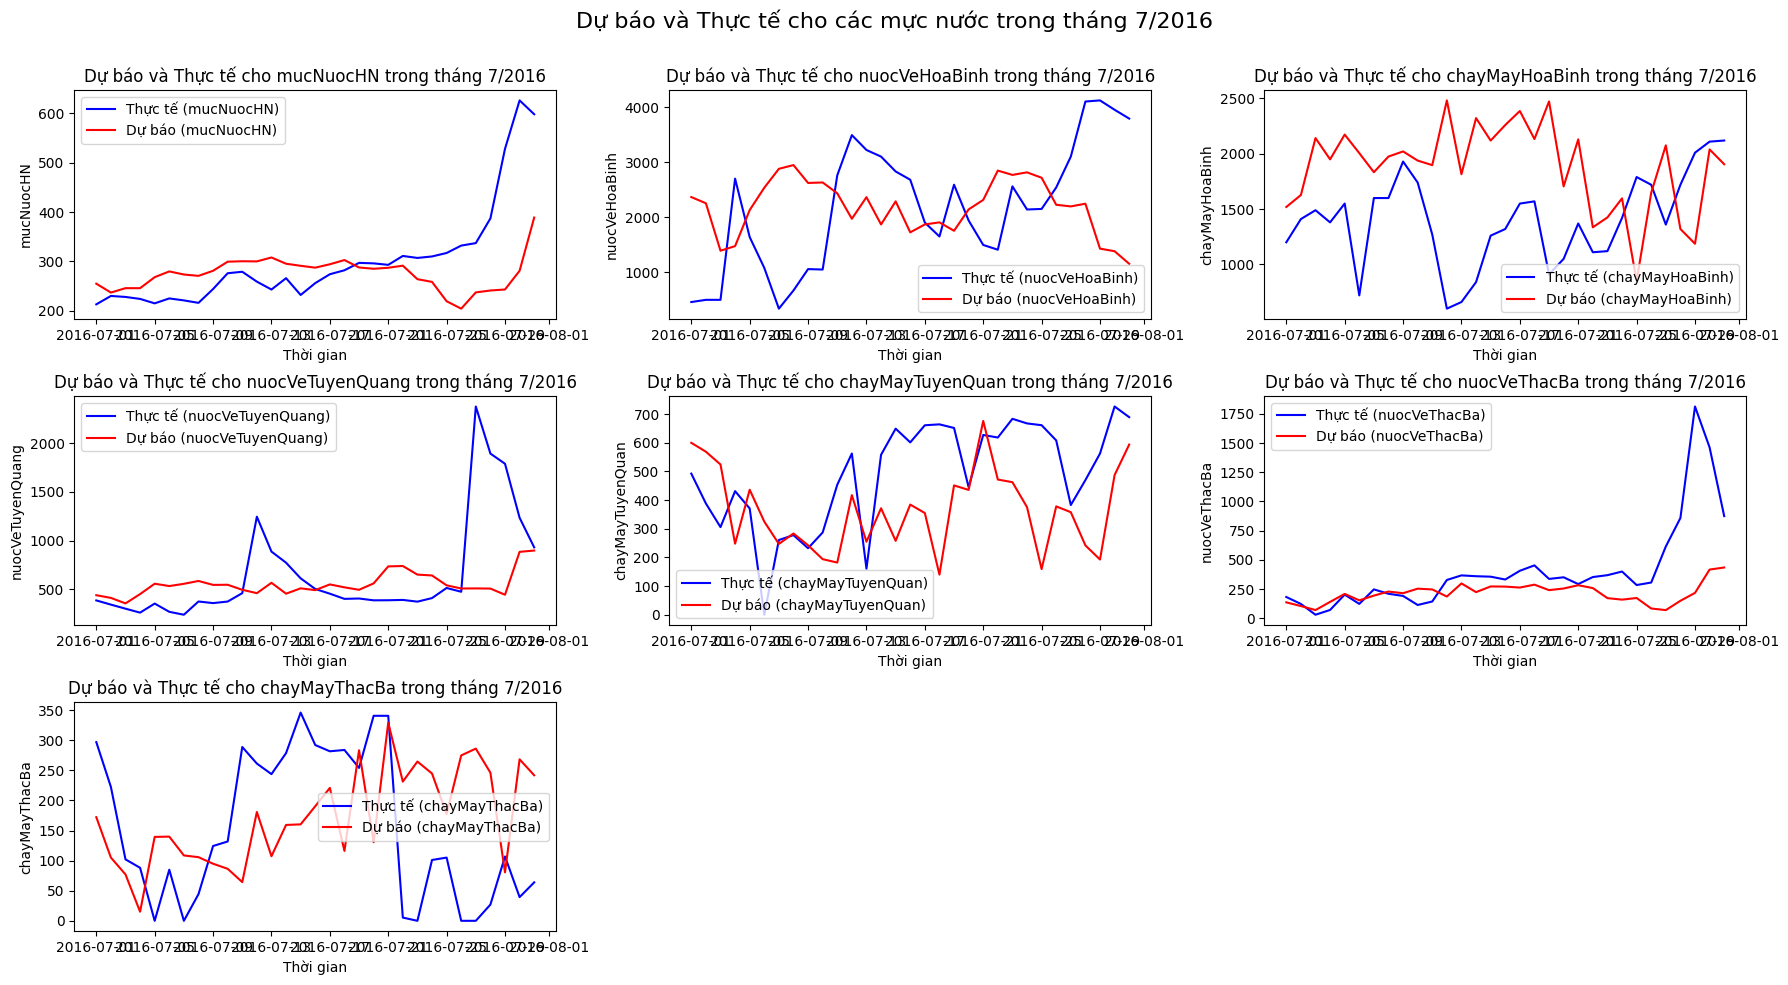

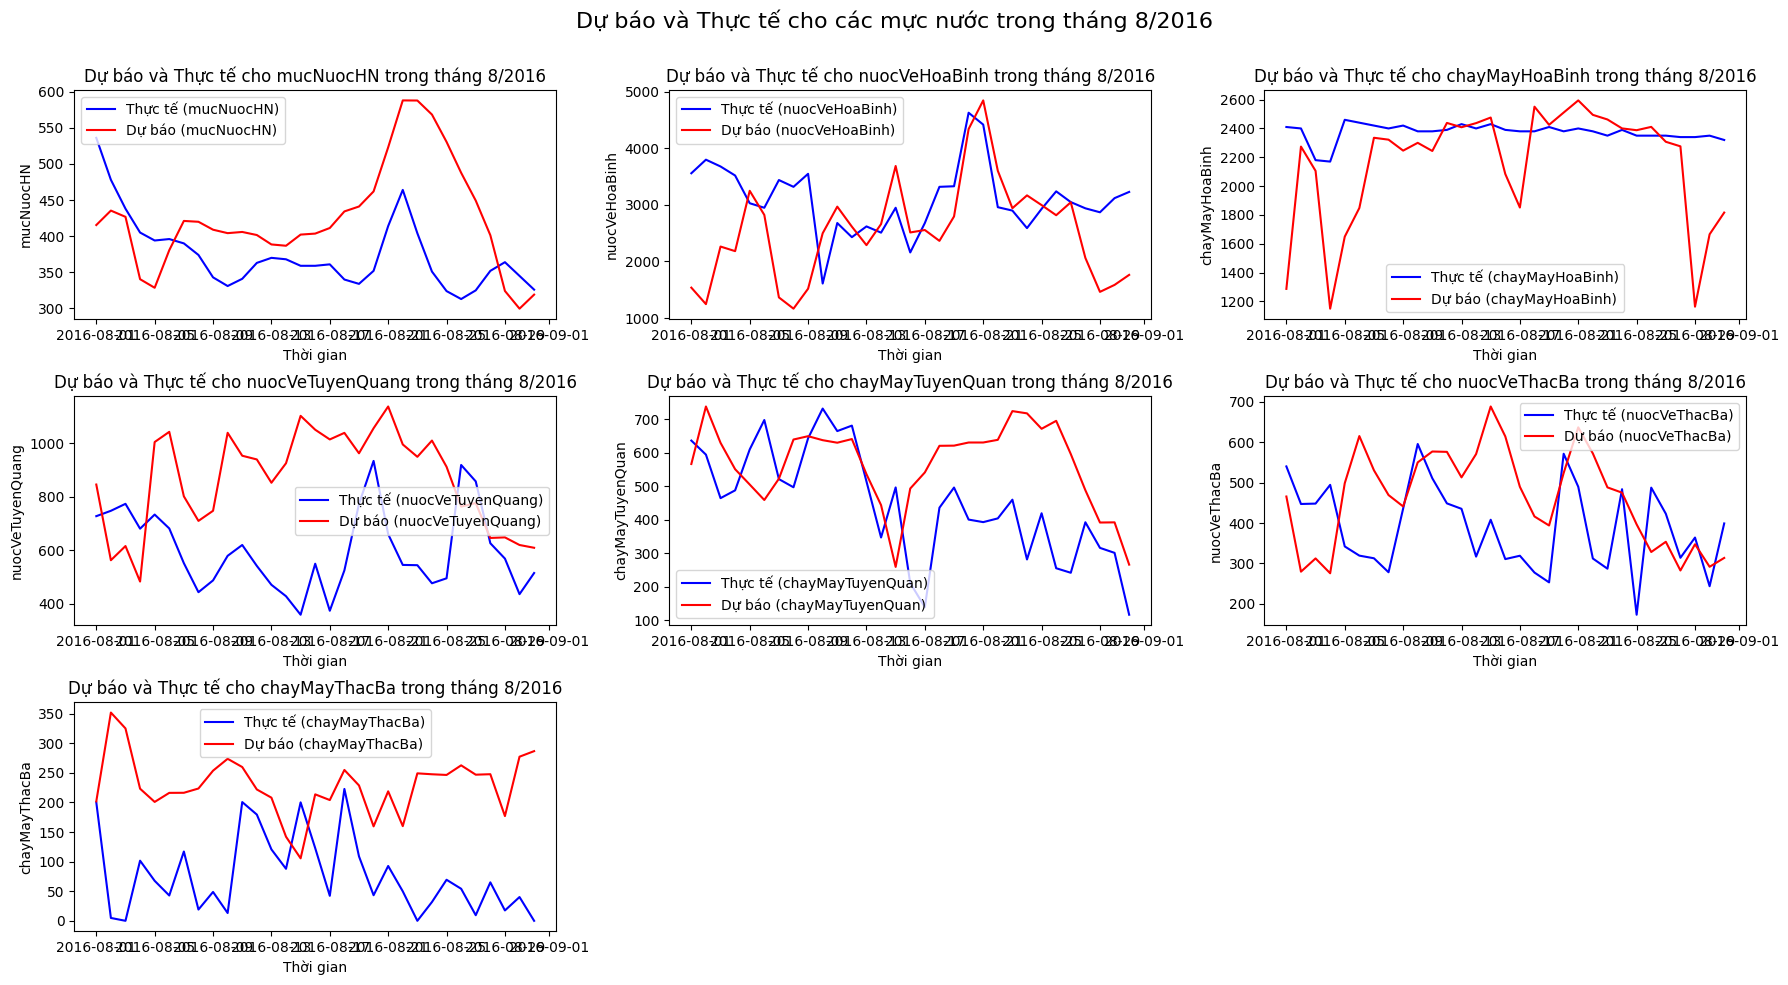

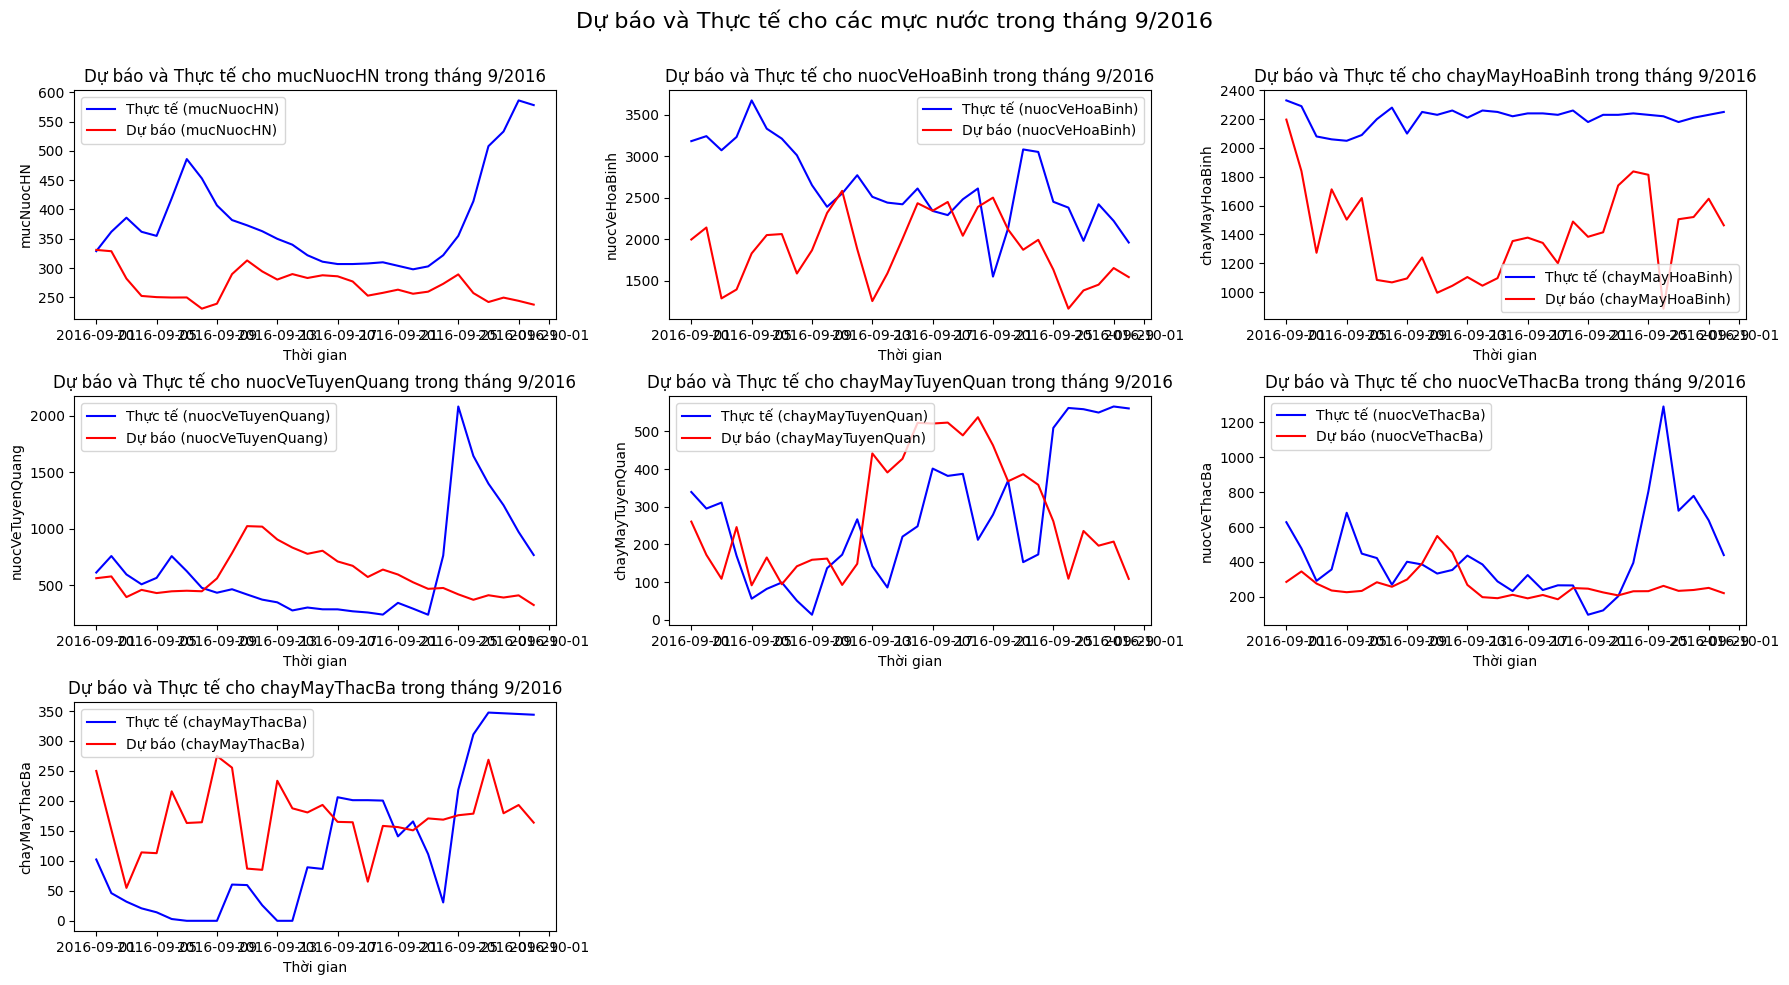

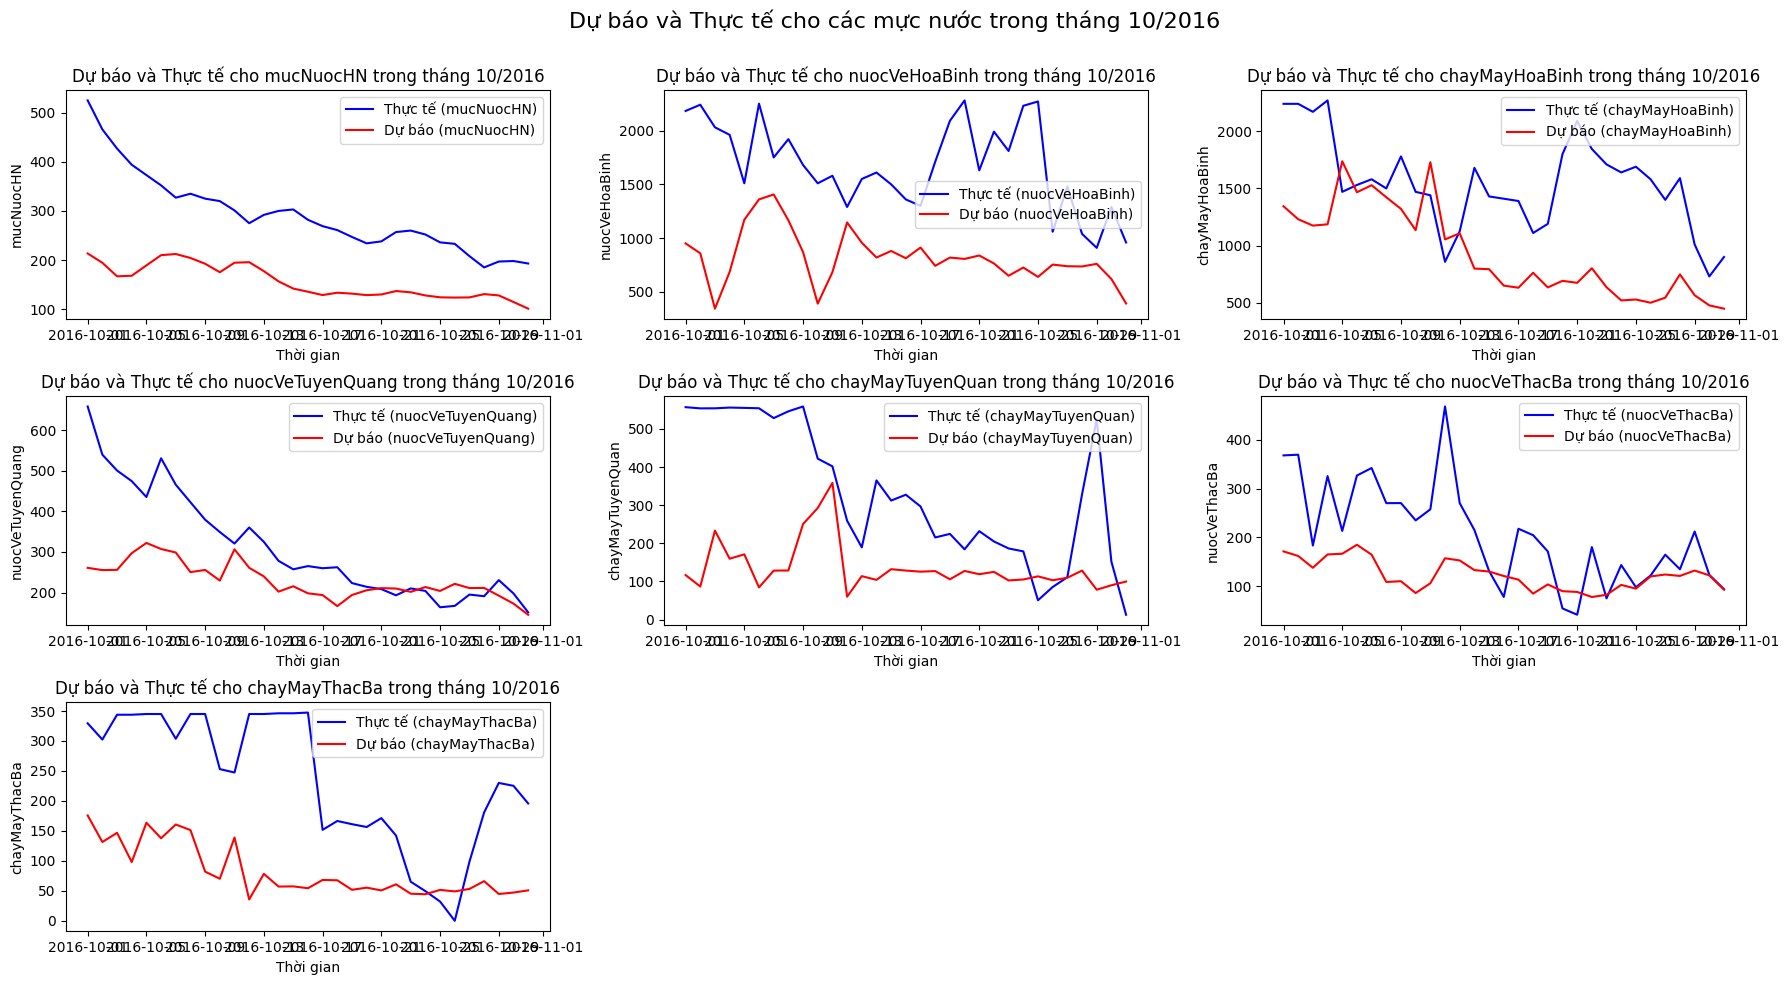

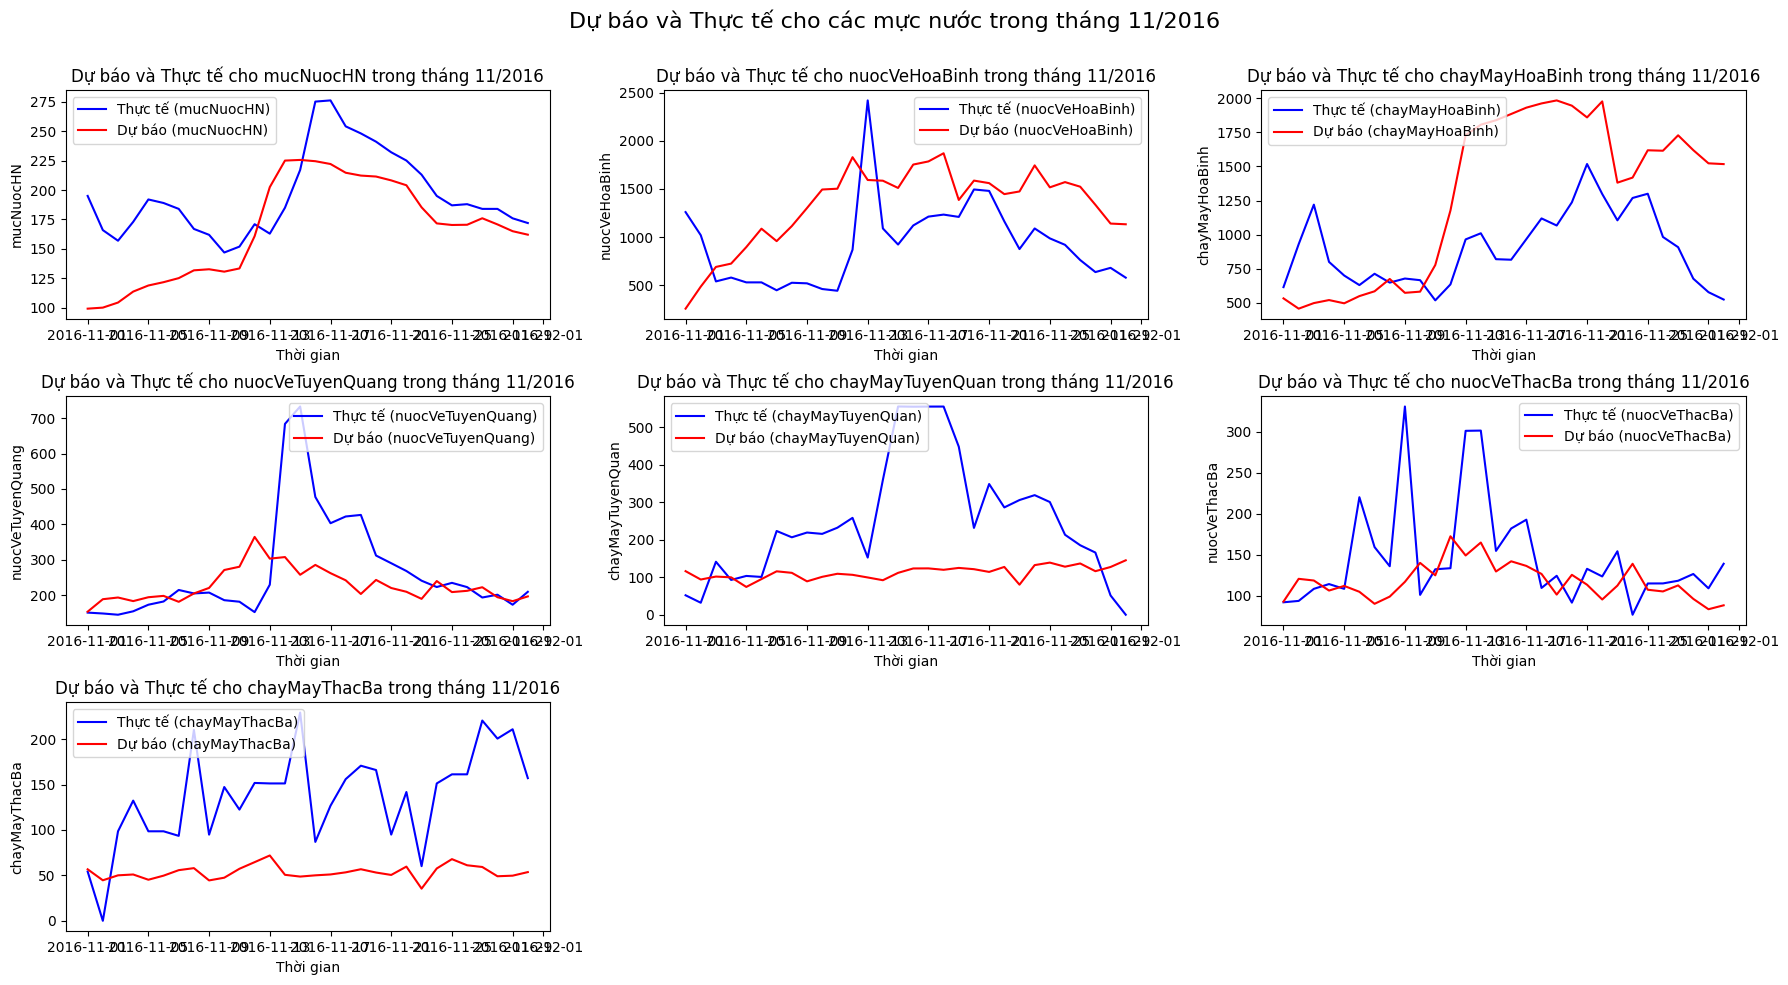

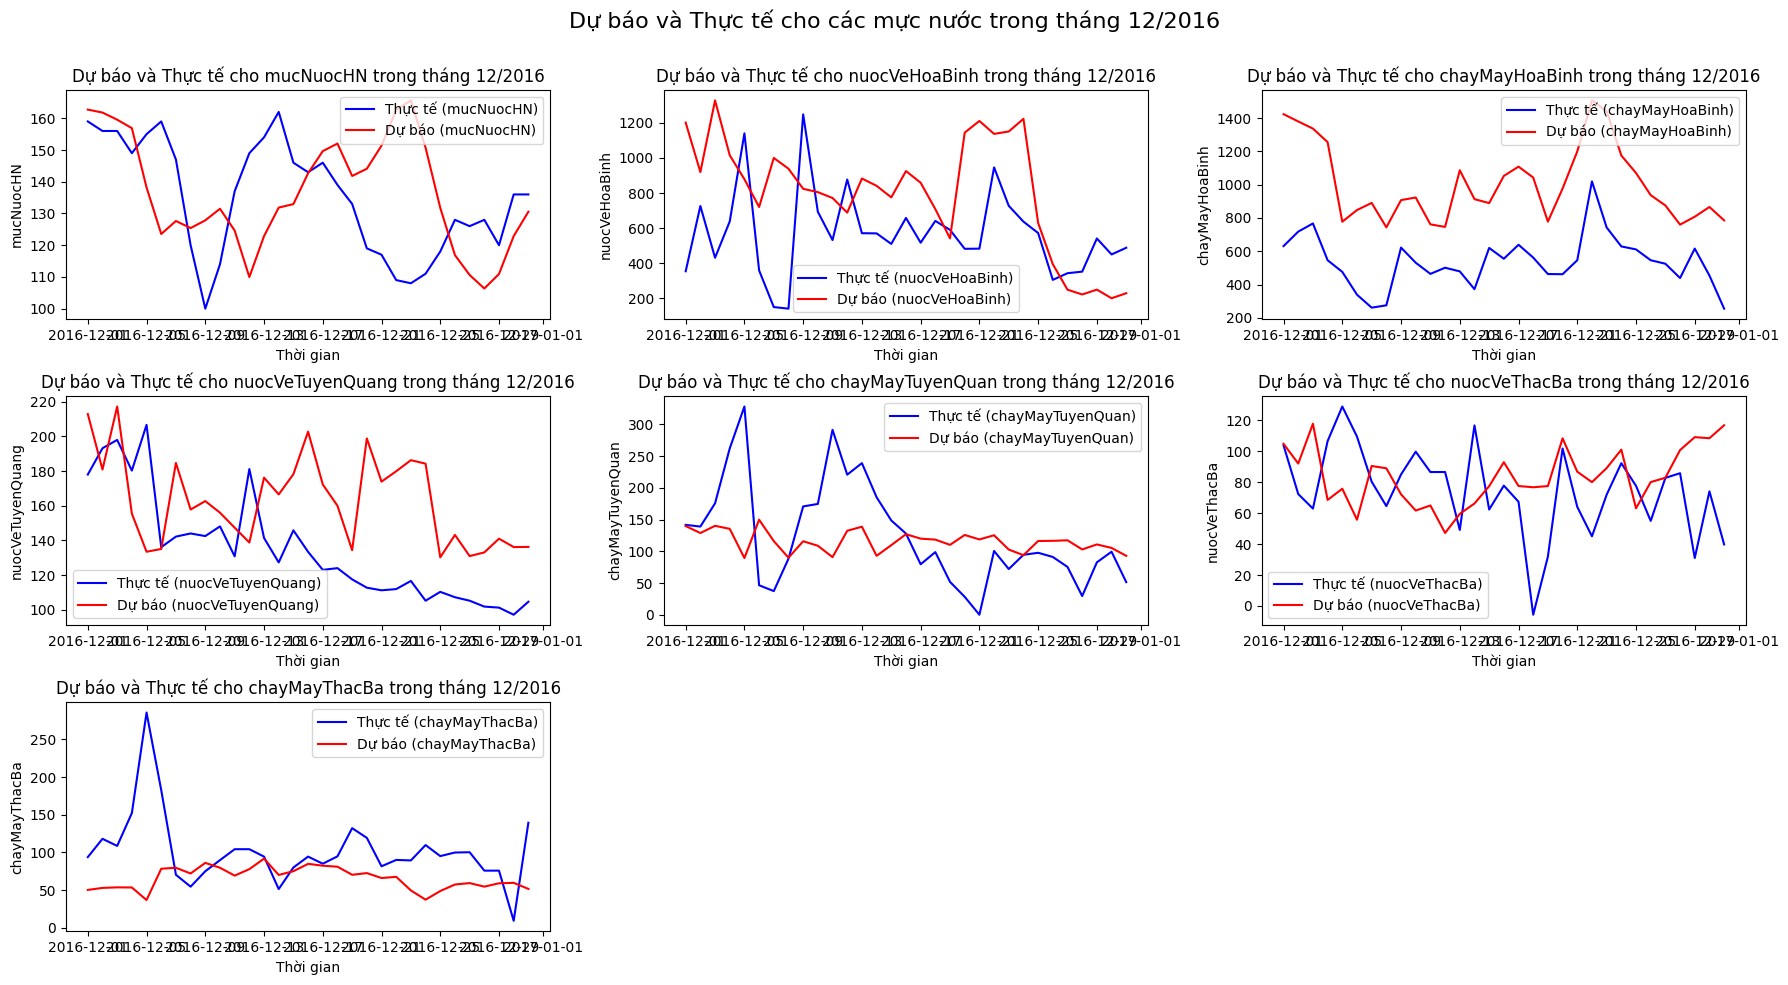

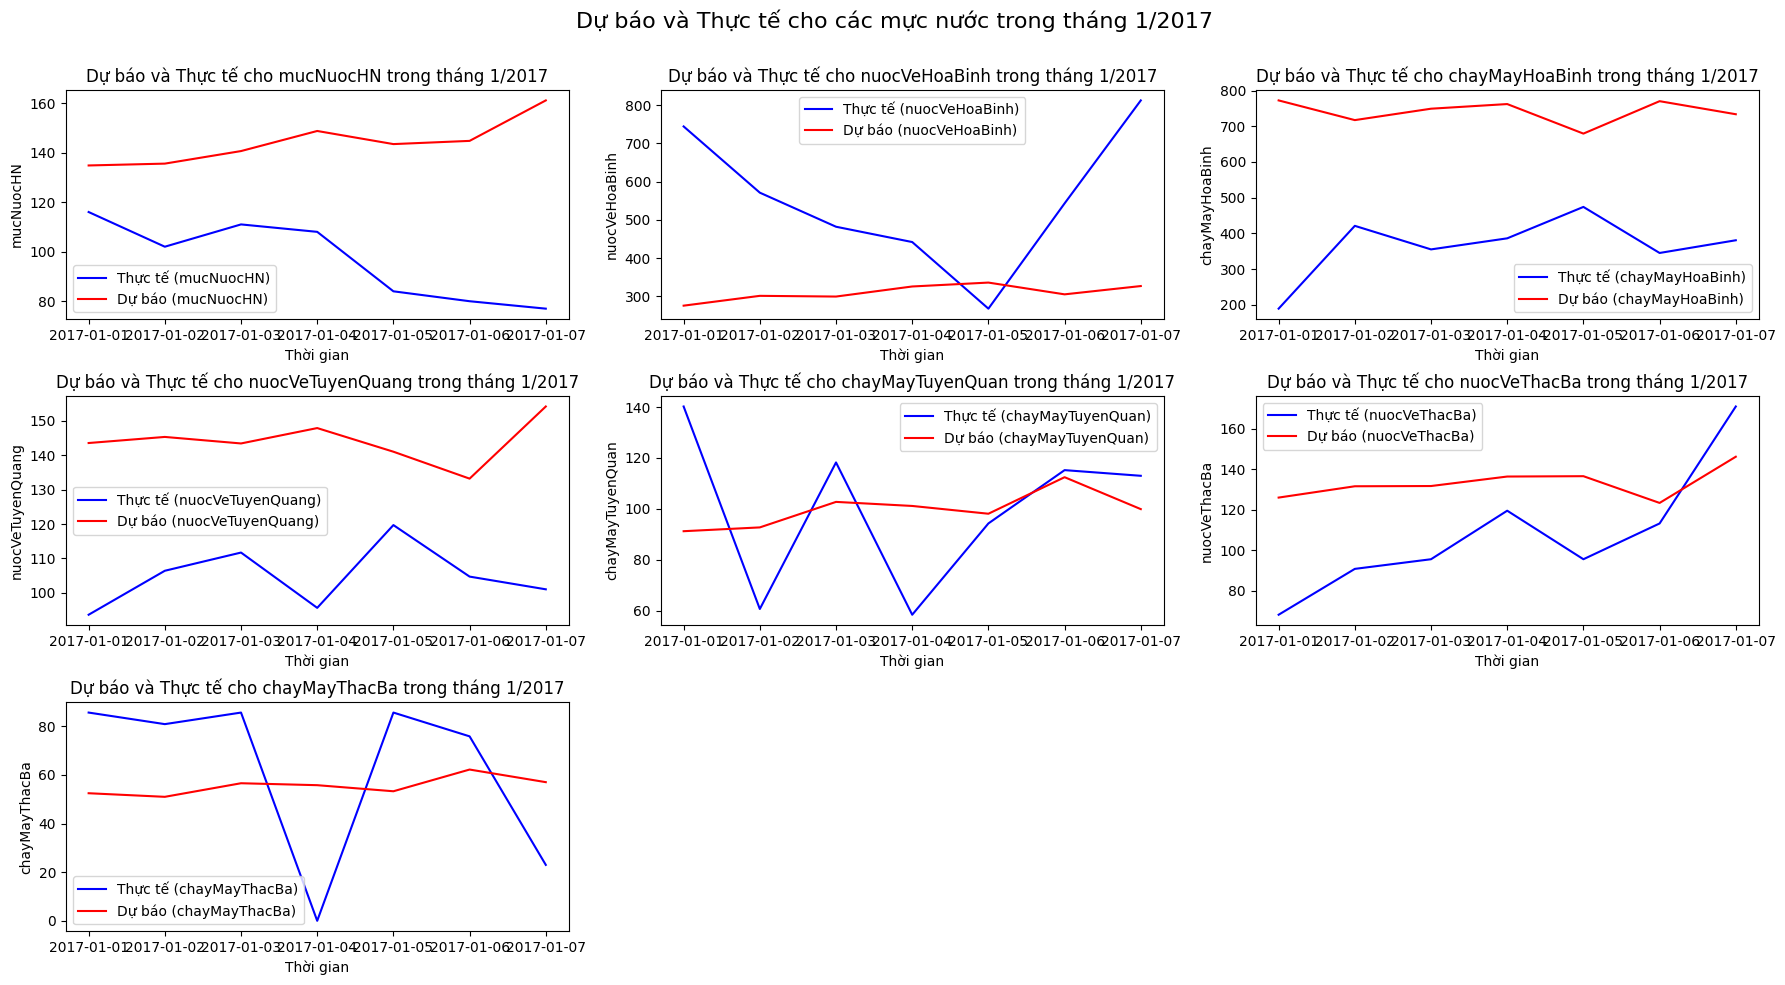

In [99]:
for year in unique_years:
    for month in range(1, 13):  # Lặp qua các tháng từ 1 đến 12
        mask = (years == year) & (months == month)  # Chọn dữ liệu của năm và tháng hiện tại

        # Kiểm tra nếu có dữ liệu cho tháng đó
        if mask.sum() > 0:
            plt.figure(figsize=(18, 10))
            for i, col in enumerate(columns_new):
                plt.subplot(3, 3, i + 1)
                plt.plot(dates_new[mask], y_original_scale[mask, i], label=f'Thực tế ({col})', color='blue')
                plt.plot(dates_new[mask], predictions_original_scale[mask, i], label=f'Dự báo ({col})', color='red')
                plt.xlabel('Thời gian')
                plt.ylabel(col)
                plt.legend()
                plt.title(f'Dự báo và Thực tế cho {col} trong tháng {month}/{year}')

            plt.tight_layout()
            plt.suptitle(f'Dự báo và Thực tế cho các mực nước trong tháng {month}/{year}', fontsize=16)
            plt.subplots_adjust(top=0.9)  # Để tiêu đề không bị chèn lên các biểu đồ
            plt.show()